# Agent interaction analysis
## Step by step data extraction

In [2]:
# Imports
import glob
import pandas as pd
import torch
from pathlib import Path
from matplotlib import pyplot as plt
from egg.zoo.pop.scripts.analysis_tools.analysis import interaction_to_dataframe, name_to_idx, extract_name
import seaborn as sns

# used in a later part of the script :
import numpy as np
import scipy

# diagnostic classifier
import egg.zoo.pop.scripts.analysis_tools.diagnostic_classifier as dc

# clustering
from sklearn.cluster import OPTICS, cluster_optics_dbscan, KMeans
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

# clustered images observation
from egg.zoo.pop.data import get_dataloader
import numpy as np
import random
from matplotlib.pyplot import cm

# PCA
from sklearn.decomposition import PCA
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)



/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.1.9) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [7]:
# fill the interaction_files table with paths of interaction files to analyse
interaction_files = glob.glob("/homedtcl/mmahaut/projects/experiments/int_im1k/imagenet*")
#interaction_files.append("/homedtcl/mmahaut/projects/experiments/int_fuller/None['vgg11','vit','resnet152', 'inception','swin','dino']['vgg11','vit','resnet152', 'inception','swin','dino']")
print(len(interaction_files), "files : ")
for f in interaction_files:
    print(f)
# load files, then put them in easily handled dataframes
inters = [torch.load(file) for file in interaction_files]
df_inters = [interaction_to_dataframe(inter) for inter in inters] 
# print("available information in dataframe : \n", df_inters[0].columns)



37 files : 
/homedtcl/mmahaut/projects/experiments/int_im1k/imagenet_valNone['inception']['dino']
/homedtcl/mmahaut/projects/experiments/int_im1k/imagenet_valNone['vit']['resnet152']
/homedtcl/mmahaut/projects/experiments/int_im1k/imagenet_valNone['inception']['vgg11']
/homedtcl/mmahaut/projects/experiments/int_im1k/imagenet_valNone['swin']['inception']
/homedtcl/mmahaut/projects/experiments/int_im1k/imagenet_valNone['inception']['resnet152']
/homedtcl/mmahaut/projects/experiments/int_im1k/imagenet_valNone['resnet152']['swin']
/homedtcl/mmahaut/projects/experiments/int_im1k/imagenet_valNone['swin']['dino']
/homedtcl/mmahaut/projects/experiments/int_im1k/imagenet_valNone['vgg11']['resnet152']
/homedtcl/mmahaut/projects/experiments/int_im1k/imagenet_valNone['resnet152']['vit']
/homedtcl/mmahaut/projects/experiments/int_im1k/imagenet_valNone['vgg11']['vgg11']
/homedtcl/mmahaut/projects/experiments/int_im1k/imagenet_valNone['vit']['dino']
/homedtcl/mmahaut/projects/experiments/int_im1k/ima

In [69]:
# if we want to work from a csv file instead
# for i,df_inter in enumerate(df_inters):
#     print(df_inter.to_csv(base_path / (interaction_files[i] + ".csv")))

### A few numbers to explain the data
#### Looking at accuracy and its significance

In [3]:
indexed_printing = True # UI : if set to false, file names are used instead of indices

# check performance scores of all loaded files :
for i, df_inter in enumerate(df_inters):
    acc = (df_inter.batch_number % 64 == df_inter.receiver_output).mean().item()
    # Details out population
    if df_inter.sender_idx.nunique() != 1 and df_inter.recv_idx.nunique() != 1:
        print(f"---------- {interaction_files[i]} ----------")
        print(f"average accuracy = {acc}")
        print(f"{df_inter.sender_idx.nunique()} sender, {df_inter.recv_idx.nunique()} receivers")
        for sidx in range(df_inter.sender_idx.nunique()):
            for ridx in range(df_inter.recv_idx.nunique()):
                select_inters = df_inter[df_inter.sender_idx == sidx][df_inter.recv_idx == ridx]
                _acc = (select_inters.batch_number % 64 == select_inters.receiver_output).mean().item()
                print(f"{sidx} - {ridx} accuracy = {_acc}")
    else :
        #single agent simple version (clearest version temporarly broken, printing file names)
        #_indexes = [name_to_idx(name) for name in extract_name(interaction_files[i])]
        #print(f"{_indexes[0]} - {_indexes[1]} accuracy = {acc}" if indexed_printing else f"{interaction_files[i]}  accuracy = {acc}")
        print(f"{interaction_files[i]}\n acc {acc}")


/homedtcl/mmahaut/projects/experiments/int_het/None['dino']['resnet152']
 acc 0.9995554765291608
/homedtcl/mmahaut/projects/experiments/int_het/None['resnet152']['dino']
 acc 0.9990665007112376
/homedtcl/mmahaut/projects/experiments/int_het/None['vit']['vgg11']
 acc 0.9857085704125178
/homedtcl/mmahaut/projects/experiments/int_het/None['dino']['swin']
 acc 0.9926875889046942
/homedtcl/mmahaut/projects/experiments/int_het/None['swin']['vit']
 acc 0.9889535917496444
/homedtcl/mmahaut/projects/experiments/int_het/None['swin']['dino']
 acc 0.9762846728307255
/homedtcl/mmahaut/projects/experiments/int_het/None['vgg11']['vgg11']
 acc 0.9998444167852063
/homedtcl/mmahaut/projects/experiments/int_het/None['vgg11']['resnet152']
 acc 0.9973995376955903
/homedtcl/mmahaut/projects/experiments/int_het/None['dino']['vit']
 acc 0.9955992176386913
---------- /homedtcl/mmahaut/projects/experiments/int_het/None['vgg11','vit','resnet152', 'inception','swin','dino']['vgg11','vit','resnet152', 'inception',

/tmp/ipykernel_311991/1126963062.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  select_inters = df_inter[df_inter.sender_idx == sidx][df_inter.recv_idx == ridx]


0 - 5 accuracy = 0.9152293741109531
1 - 0 accuracy = 0.7867843172119487
1 - 1 accuracy = 0.9907539118065434
1 - 2 accuracy = 0.8725106685633002
1 - 3 accuracy = 0.7766936344238976
1 - 4 accuracy = 0.9232974751066856
1 - 5 accuracy = 0.858174786628734
2 - 0 accuracy = 0.9721950568990043
2 - 1 accuracy = 0.8850240042674253
2 - 2 accuracy = 0.9985108463726885
2 - 3 accuracy = 0.9591927453769559
2 - 4 accuracy = 0.849195412517781
2 - 5 accuracy = 0.971728307254623
3 - 0 accuracy = 0.8643536628733998
3 - 1 accuracy = 0.7165496088193457
3 - 2 accuracy = 0.8998933143669986
3 - 3 accuracy = 0.9787295519203414
3 - 4 accuracy = 0.6928565078236131
3 - 5 accuracy = 0.8771781650071123
4 - 0 accuracy = 0.7459326102418208
4 - 1 accuracy = 0.9234308321479374
4 - 2 accuracy = 0.838949146514936
4 - 3 accuracy = 0.7486442034139402
4 - 4 accuracy = 0.9761735419630156
4 - 5 accuracy = 0.8079658605974396
5 - 0 accuracy = 0.9577035917496444
5 - 1 accuracy = 0.8737553342816501
5 - 2 accuracy = 0.9639713726884

---------- /homedtcl/mmahaut/projects/experiments/int_het/None['vgg11','vit','resnet152', 'inception','swin','dino']['vgg11','vit','resnet152', 'inception','swin','dino'] ----------
average accuracy = 0.8780456031689584
6 sender, 6 receivers


/tmp/ipykernel_311991/3557097215.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  select_inters = df_inter[df_inter.sender_idx == sidx][df_inter.recv_idx == ridx]


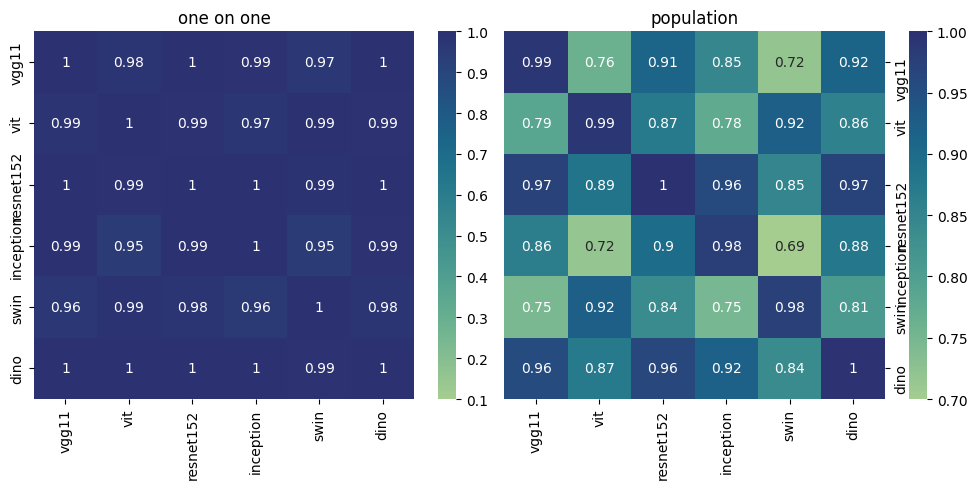

In [4]:
# still unstable : same as previous but with a heatmap
# unstable because it requires that all one on one and a population be used
models = ['vgg11','vit','resnet152', 'inception','swin','dino']
one_one_accs = torch.empty((len(models),len(models)))
_accs = None
for i, df_inter in enumerate(df_inters):
    acc = (df_inter.batch_number % 64 == df_inter.receiver_output).mean().item()
    if df_inter.sender_idx.nunique() != 1 or df_inter.recv_idx.nunique() != 1:
        print(f"---------- {interaction_files[i]} ----------")
        print(f"average accuracy = {acc}")
        print(f"{df_inter.sender_idx.nunique()} sender, {df_inter.recv_idx.nunique()} receivers")
        _accs = torch.empty((df_inter.sender_idx.nunique(),df_inter.recv_idx.nunique()))
        for sidx in range(df_inter.sender_idx.nunique()):
            for ridx in range(df_inter.recv_idx.nunique()):
                select_inters = df_inter[df_inter.sender_idx == sidx][df_inter.recv_idx == ridx]
                _acc = (select_inters.batch_number % 64 == select_inters.receiver_output).mean().item()
                _accs[sidx][ridx] = _acc
                
    else :
        _indexes = [name_to_idx(name) for name in extract_name(interaction_files[i])]
        #assert one_one_accs[_indexes[0]][_indexes[1]] == 0, f"tried to put value in non-empty slot : got {one_one_accs[_indexes[0]][_indexes[1]]}"
        one_one_accs[_indexes[0]][_indexes[1]] = acc
        
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True

df1 = pd.DataFrame(one_one_accs, columns=models, index=models)
df2 = pd.DataFrame(_accs, columns=models, index=models)

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.01)

sns.heatmap(df1, cmap="crest", ax=ax1, vmax=1, vmin = 0.1, cbar=True, annot=True)
sns.heatmap(df2, cmap="crest", ax=ax2, vmax=1, vmin = 0.7, cbar=True, annot=True)


ax2.yaxis.tick_right()
ax1.set_title('one on one')
#ax2.set_title('population testing accuracy')
ax2.set_title('population')

fig.subplots_adjust(wspace=0.001)
plt.show()


df_heatmap = pd.DataFrame(one_one_accs, columns=models, index=models)

In [5]:
# !! WARNING This cell is only relevant if both a population and corresponding one-on-one are loaded
# Is there a significant difference between one on one and population communication ?
# Is there a difference between homogeneous and heterogeneous populations ?

# get 1 - 1 accuracies
a = []
rs_pairs = []
pop_inters = pd.DataFrame()
for i, df_inter in enumerate(df_inters):
    if df_inter.sender_idx.nunique() == 1 and df_inter.recv_idx.nunique() == 1:
        # get index
        sidx = name_to_idx(extract_name(interaction_files[i])[0])
        ridx = name_to_idx(extract_name(interaction_files[i])[1])
        rs_pairs.append((sidx, ridx))
        
        _a_acc = (df_inter.batch_number % 64 == df_inter.receiver_output).mean().item()
        a.append(_a_acc)
    else :
        # use this pass to get the population interaction file from the bunch
        pop_inters = df_inter

b=[]
# get pop accuracy
for sidx, ridx in rs_pairs:
    selected_inters = pop_inters[pop_inters.sender_idx == sidx][pop_inters.recv_idx == ridx]
    _b_acc = (selected_inters.batch_number % 64 == selected_inters.receiver_output).mean()
    b.append(_b_acc)


a = [_val for i,_val in enumerate(a) if not pd.isnull(b)[i]]
b = [_val for _val in b if not pd.isnull(_val)]
print(a,b)
print("PASSED 3")

# paired wilcoxon : no proof of normal distribution
print("Wilcoxon :", scipy.stats.wilcoxon(a,b)) # a is less than b
print("Wilcoxon (a<b):", scipy.stats.wilcoxon(a,b, alternative="less")) # a is less than b

# paired fischer : normal distribution
print("Fischer :", scipy.stats.ttest_rel(a,b))
print("Fischer (a<b):", scipy.stats.ttest_rel(a,b, alternative="less"))

/tmp/ipykernel_311991/2350941654.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  selected_inters = pop_inters[pop_inters.sender_idx == sidx][pop_inters.recv_idx == ridx]


[0.9995554765291608, 0.9990665007112376, 0.9857085704125178, 0.9926875889046942, 0.9889535917496444, 0.9762846728307255, 0.9998444167852063, 0.9973995376955903, 0.9955992176386913, 0.9929543029871978, 0.999977773826458, 0.9710170697012802, 0.9534806187766715, 0.9935321834992887, 0.9582814722617354, 0.9898426386913229, 0.9947990753911806, 0.9683499288762447, 0.9810855263157895, 0.9999333214793741, 0.9999110953058321, 0.9983552631578947, 0.9995110241820768, 0.9926875889046942, 0.9916651849217639, 0.9534139402560455, 0.9974884423897582, 0.9782405761024182, 0.9992887624466572, 0.997043918918919, 0.9919763513513513, 0.9893314366998578, 0.9938878022759602, 0.9990887268847796, 0.9622599573257468, 0.9992887624466572] [0.963971372688478, 0.971728307254623, 0.7867843172119487, 0.8378156116642959, 0.9234308321479374, 0.8079658605974396, 0.9904205192034139, 0.9113175675675675, 0.8737553342816501, 0.858174786628734, 0.9965771692745377, 0.7766936344238976, 0.6928565078236131, 0.9232974751066856, 0.7

#### Analysis of message differences

In [8]:
def euler_distance(a,b):
    # euler distance
    s = (a.loc[:,a.columns.str.contains('dim')].reset_index() - b.loc[:,b.columns.str.contains('dim')].reset_index())**2
    return s.sum(axis=1)**0.5

def cosine_distance(a,b):
    # cosine distance
    a = a.set_index("batch_number")
    b = b.set_index("batch_number")
    cos_dis = []
    a_dim = a.loc[:,a.columns.str.contains('dim')]
    # print(a_dim)
    a_dim = a_dim.values[:,1:]
    b_dim = b.loc[:,b.columns.str.contains('dim')].values[:,1:]
    # print(a_dim.shape, b_dim.shape)
    # print([key for key in a_dim.columns if key in b_dim.columns])
    # print("test", a_dim.sample(3).values)
    cos_dis = 1 - torch.nn.functional.cosine_similarity(torch.Tensor(a_dim), torch.Tensor(b_dim))
    return cos_dis

36 1619712


<AxesSubplot:xlabel='idx1', ylabel='distance'>

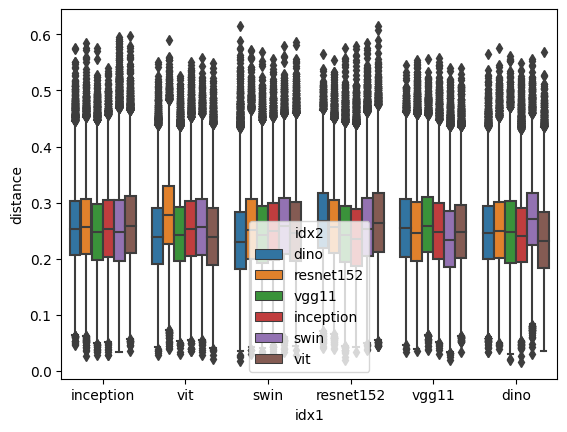

In [9]:
df_pop = df_inters[21]
df_ones = df_inters[:21] + df_inters[22:]
all_dist = np.concatenate([
    cosine_distance(
        df_pop[len(df_ones[i])*i:len(df_ones[i])*(i+1)],
        df_ones[i]).numpy() for i in range(len(df_ones))
])

all_indexes = np.array([
    [
        names
        for names in extract_name(interaction_files[i])
    ] for i in range(len(df_inters)) if i!=21
])

# sub optimal but then again it works, and its 1:10am
all_indexes2=[[],[]]
all_indexes2[0] = np.concatenate([[name] * len(df_ones[0]) for name in all_indexes.T[0]])
all_indexes2[1] = np.concatenate([[name] * len(df_ones[1]) for name in all_indexes.T[1]])

print(len(all_indexes.T[0]), len(all_dist))
inter_distances = pd.DataFrame({"distance":all_dist, "idx1":all_indexes2[0], "idx2":all_indexes2[1],"Message distance between senders from :":"One from each"})
sns.boxplot(y=inter_distances.distance,x=inter_distances.idx1, hue=inter_distances.idx2)

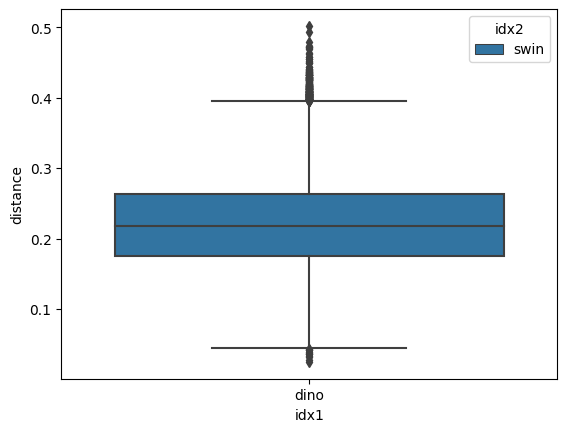

In [10]:
df_ones_distances = pd.DataFrame(columns=["distance","idx1","idx2"])

for idx1 in range(6):
    for idx2 in range(6):
        for i,f in enumerate(interaction_files):
            if i != 21:
                if name_to_idx(extract_name(f)[0]) == idx1:
                    a = df_inters[i]
                    break
                elif name_to_idx(extract_name(f)[1]) == idx2:
                    b = df_inters[i]
                    break
        if idx1 != idx2 and not (len(a) == 0 or  len(b) == 0):
            _dist=cosine_distance(a,b)
            _new_df_dist = pd.DataFrame({"distance":_dist, "idx1":arch_names[idx1], "idx2":arch_names[idx2],"Message distance between senders from :":"One-on-one"})
            df_ones_distances = pd.concat([df_distances,_new_df_dist])
            

sns.boxplot(y=df_ones_distances.distance,x=df_ones_distances.idx1, hue=df_ones_distances.idx2)
# plt.ylim(0, 2e-7) # TODO : deal with the scales
plt.show()

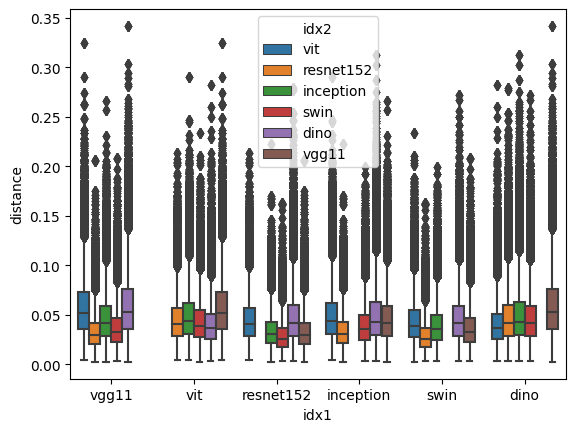

<AxesSubplot:>

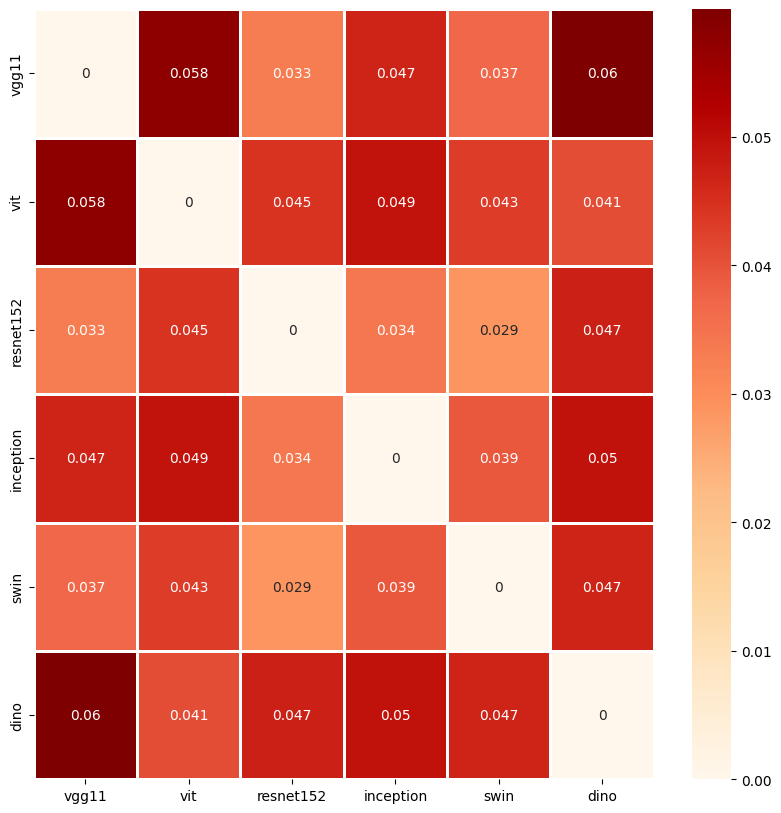

In [11]:
# given the same image, how different are the messages given by different senders
arch_names = ['vgg11','vit','resnet152','inception','swin','dino']
df_distances = pd.DataFrame(columns=["distance","idx1","idx2"])

df_inter_one = pd.DataFrame()

# display distances
for i,df_inter in enumerate(df_inters):
    # am I in the single agent case ?
    if df_inter.recv_idx.nunique() == 1 and df_inter.sender_idx.nunique() == 1:
        pass
    # am I in the multi-agent case ?
    else:
        heatmap = np.zeros((df_inter.sender_idx.nunique(), df_inter.recv_idx.nunique()))
        for idx1 in range(df_inter.sender_idx.nunique()):
            for idx2 in range(df_inter.recv_idx.nunique()):
                a = df_inter[df_inter.sender_idx == idx1]
                b = df_inter[df_inter.sender_idx == idx2]
                if idx1 != idx2 and not (len(a) == 0 or  len(b) == 0):
                    # print(idx1,idx2)
                    _dist=cosine_distance(a,b)
                    _new_df_dist = pd.DataFrame({"distance":_dist, "idx1":arch_names[idx1], "idx2":arch_names[idx2],"Message distance between senders from :":"Population"})
                    df_distances = pd.concat([df_distances,_new_df_dist])
                    heatmap[idx1,idx2] = _dist.mean()
            

sns.boxplot(y=df_distances.distance,x=df_distances.idx1, hue=df_distances.idx2)
# plt.ylim(0, 2e-7) # TODO : deal with the scales
plt.show()

df_heatmap = pd.DataFrame(heatmap, columns=arch_names, index=arch_names)
# plot it with seaborn
plt.figure(figsize=(10,10))
sns.heatmap(
    df_heatmap,
    cmap='OrRd',
    linewidth=1,
    annot=True
)

<AxesSubplot:xlabel='Message distance between senders from :', ylabel='Distance'>

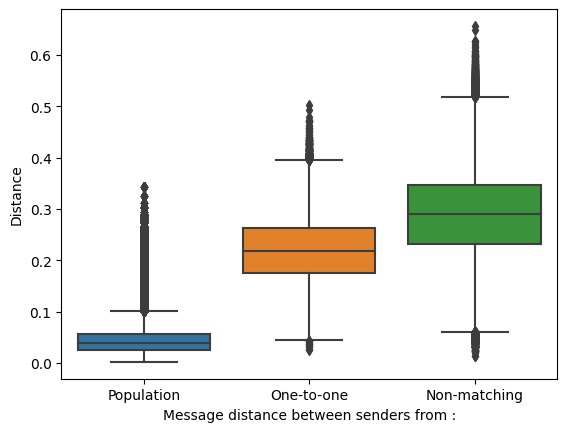

In [13]:
df_all = pd.concat([df_distances,df_ones_distances,inter_distances, df_random])
df_all = df_all.rename({'distance': 'Distance'}, axis='columns')
df_all["Message distance between senders from :"].replace(["One-on-one"],["One-to-one"], inplace=True)

sns.boxplot(df_all[df_all["Message distance between senders from :"] != "One from each"], y="Distance",x="Message distance between senders from :")


5 5


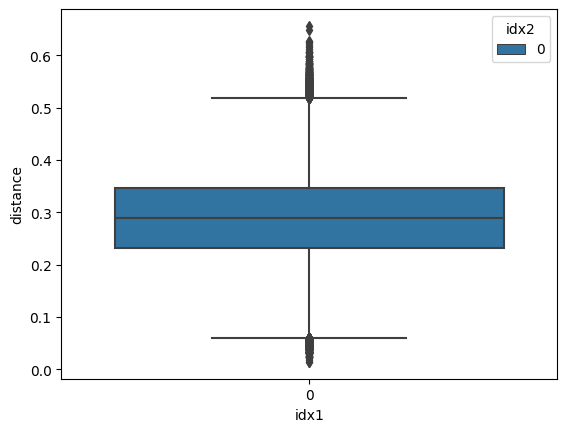

In [12]:
pop_idx = 21 #index of population in df_inters
# baseline with shuffling to make sure that that we're not comparing the same images necesseraly
df_random = pd.DataFrame(columns=["distance","idx1","idx2"])

a = df_inters[pop_idx][df_inters[pop_idx].sender_idx == 0].sample(frac=1)
b = df_inters[pop_idx][df_inters[pop_idx].sender_idx == 1].sample(frac=1)
if not (len(a) == 0 or  len(b) == 0):
    print(idx1,idx2)
    _dist=cosine_distance(a,b)
    _new_df_dist = pd.DataFrame({"distance":_dist, "idx1":0, "idx2":0, "Message distance between senders from :":"Non-matching"})
    df_random = pd.concat([df_random,_new_df_dist])

# a = df_inters[pop_idx][df_inters[pop_idx].sender_idx == 0]
# b = df_inters[pop_idx][df_inters[pop_idx].sender_idx == 2]
# if not (len(a) == 0 or  len(b) == 0):
#     _dist=cosine_distance(a,b)
#     _new_df_dist = pd.DataFrame({"distance":_dist, "idx1":0, "idx2":2})
#     df_random = pd.concat([df_random,_new_df_dist])
if(len(df_random.distance)!=0):
    sns.boxplot(y=df_random.distance,x=df_random.idx1, hue=df_random.idx2)
    # plt.ylim(0, 2e-7) # TODO : deal with the scales
    plt.show()

## Diagnostic classifier
Beware, some of the following experiments take some time

In [11]:
for i, df_inter in enumerate(df_inters):
    if df_inter.sender_idx.nunique() != 1 and df_inter.recv_idx.nunique() != 1:
        print(f"---------- {interaction_files[i]} ----------")
        print(f"{df_inter.sender_idx.nunique()} sender, {df_inter.recv_idx.nunique()} receivers")
        for sidx in range(df_inter.sender_idx.nunique()):
            for ridx in range(df_inter.recv_idx.nunique()):
                select_inters = df_inter[df_inter.sender_idx == sidx][df_inter.recv_idx == ridx]
                select_inters.message =  torch.tensor([select_inters[f"dim_{i}"].values for i in range(16)]).T
                print(sidx, ridx, dc.run_dc(interaction_files[i], n_samples=44992,n_epochs=500))

    else :
        df_inter.message = torch.tensor([df_inter[f"dim_{i}"].values for i in range(16)]).T
        print(interaction_files[i][4:] if interaction_files[i][:4] == "None" else interaction_files[i],"\t\t", dc.run_dc(interaction_files[i], n_samples=44992,n_epochs=50))


tensor(44.5817, device='cuda:0')
/homedtcl/mmahaut/projects/experiments/int_het/None['dino']['resnet152'] 		 None
tensor(44.2850, device='cuda:0')
/homedtcl/mmahaut/projects/experiments/int_het/None['resnet152']['dino'] 		 None
tensor(44.5128, device='cuda:0')
/homedtcl/mmahaut/projects/experiments/int_het/None['vit']['vgg11'] 		 None
tensor(44.4034, device='cuda:0')
/homedtcl/mmahaut/projects/experiments/int_het/None['dino']['swin'] 		 None
tensor(45.2403, device='cuda:0')
/homedtcl/mmahaut/projects/experiments/int_het/None['swin']['vit'] 		 None
tensor(44.9607, device='cuda:0')
/homedtcl/mmahaut/projects/experiments/int_het/None['swin']['dino'] 		 None
tensor(44.4070, device='cuda:0')
/homedtcl/mmahaut/projects/experiments/int_het/None['vgg11']['vgg11'] 		 None
tensor(45.0809, device='cuda:0')
/homedtcl/mmahaut/projects/experiments/int_het/None['vgg11']['resnet152'] 		 None
tensor(44.0929, device='cuda:0')
/homedtcl/mmahaut/projects/experiments/int_het/None['dino']['vit'] 		 None
---

/tmp/ipykernel_311991/1389534806.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  select_inters = df_inter[df_inter.sender_idx == sidx][df_inter.recv_idx == ridx]
/tmp/ipykernel_311991/1389534806.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  select_inters.message =  torch.tensor([select_inters[f"dim_{i}"].values for i in range(16)]).T


tensor(45.0491, device='cuda:0')
0 0 None
tensor(45.3596, device='cuda:0')
0 1 None
tensor(45.4612, device='cuda:0')
0 2 None
tensor(45.2541, device='cuda:0')
0 3 None
tensor(45.1140, device='cuda:0')
0 4 None
tensor(45.3303, device='cuda:0')
0 5 None
tensor(44.8257, device='cuda:0')
1 0 None
tensor(45.3387, device='cuda:0')
1 1 None
tensor(45.1856, device='cuda:0')
1 2 None
tensor(45.7384, device='cuda:0')
1 3 None
tensor(45.2078, device='cuda:0')
1 4 None
tensor(45.2701, device='cuda:0')
1 5 None
tensor(45.2521, device='cuda:0')
2 0 None
tensor(45.0740, device='cuda:0')
2 1 None
tensor(45.0096, device='cuda:0')
2 2 None
tensor(45.2243, device='cuda:0')
2 3 None
tensor(45.5981, device='cuda:0')
2 4 None
tensor(45.6204, device='cuda:0')
2 5 None
tensor(45.4910, device='cuda:0')
3 0 None
tensor(45.5735, device='cuda:0')
3 1 None
tensor(45.3283, device='cuda:0')
3 2 None
tensor(45.4852, device='cuda:0')
3 3 None
tensor(45.6444, device='cuda:0')
3 4 None
tensor(45.1758, device='cuda:0')
3

## Clustering
(the initial clustering methods tend not to work, skip ahead to PCA analysis)

In [ ]:
# n_points_per_cluster = 250
_inters = df_inters[0]
_inters = _inters[_inters.sender_idx == 0].sample(8000) # for OPTICS remain below 8000 or wait more than 31s in the next cell
X = _inters.loc[:,_inters.columns.str.contains('dim')].values
print(X.shape)

In [ ]:
clust = OPTICS(min_samples=15, xi=0.005, min_cluster_size=40, metric="cosine")
# Run the fit
clust.fit(X)

labels_025 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=0.025,
)

labels_05 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=0.05,
)

space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]


In [ ]:
plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = plt.cm.get_cmap("hsv", max(labels))
for klass in range(max(labels)):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color=colors(klass))
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 0.025, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.05, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title(f"Reachability Plot, {max(labels)} clusters")

# OPTICS
for klass in range(max(labels)):
    Xk = X[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], ".", color= colors(klass))
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at 0.025
for klass in range(max(labels)):
    Xk = X[labels_025 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], ".", color= colors(klass))
ax3.plot(X[labels_025 == -1, 0], X[labels_025 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.025 epsilon cut\nDBSCAN")

# DBSCAN at 0.05.
for klass in range(max(labels)):
    Xk = X[labels_05 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], ".", color= colors(klass))
ax4.plot(X[labels_05 == -1, 0], X[labels_05 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 0.05 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

In [ ]:
clust2 = KMeans(1000)
clust2.fit(X)
labels = clust2.labels_


In [ ]:
color = iter(cm.rainbow(np.linspace(0, 1, max(labels))))

In [ ]:
# plot figure
plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(1, 1)
ax = plt.subplot(G[0, :])
# ax.plot(space, np.full_like(space, 1.0, dtype=float), "k.", alpha=0.3)
print("n_classes = ",max(labels))
colors = plt.cm.get_cmap("hsv", max(labels))
for klass in range(max(labels)):
    Xk = X[clust2.labels_ == klass]
    c = next(color)
    ax.plot(Xk[:, 0], Xk[:, 1], ".", color=c)
ax.plot(X[clust2.labels_ == -1, 0], X[clust2.labels_ == -1, 1], "k+", alpha=0.1)
ax.set_title("Automatic Clustering\nKmeans")
plt.tight_layout()
plt.show()

## Qualitative analysis of similar images

In [6]:
# get the dataloader which will provide the images used at training time
def get_dl(test=True):
    test_dl,train_dl = get_dataloader(
        "/datasets/COLT/ILSVRC2012/ILSVRC2012_img_val/",
        "imagenet_val",
        batch_size=64,
        image_size=284,
        num_workers=4,
        use_augmentations=False,
    )
    return test_dl if test else train_dl

# seed must correspond to one used at training time : usually 111
def seed_all(seed):
    if not seed:
        seed = 111

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [76]:
# toolkit

# look for the most similar message in the interaction file (k-nearest)
def find_similar(message, interactions):
    _dist = 1 - torch.nn.functional.cosine_similarity(torch.Tensor(message), torch.Tensor(interactions.loc[:,interactions.columns.str.contains('dim')].values))
    return _dist.argmin().item()

# look for the n_values most similar messages in the interaction file (k-nearest)
def find_n_similar(message, interactions, n_values=1):
    _dist = 1 - torch.nn.functional.cosine_similarity(torch.Tensor(message), torch.Tensor(interactions.loc[:,interactions.columns.str.contains('dim')].values))
    return torch.topk(_dist, n_values)

# look at the image that was chosen in that case
def look_at_image(msg_indexes, interactions, train_dataset):
    # get the image chosen by the receiver on the given message
    selected_interactions = interactions.loc[msg_indexes, :].drop_duplicates()
    selected_interactions = selected_interactions.sort_values('batch_number', ascending=True)
    msg_rcv_output = selected_interactions['receiver_output'].values
    msg_batch = selected_interactions['batch_number'].values
    print(msg_rcv_output, msg_batch)
    images = []

    # message indexes have been ordered. We are forced to enumerate through the dataloader, but manage to do it only once
    _i = 0
    for batch_id, batch in enumerate(train_dataset): # This is the slow part, might work better with Dataset object ?
        if batch_id == msg_batch[_i] // 64:
            # when multiple images are taken from the same batch, then they are all processed before moving to the next one
            _j = 0
            while msg_batch[_i] // 64 == msg_batch[_i + _j] // 64:
                images.append(np.transpose(batch[2][msg_rcv_output[_i + _j]], (1, 2, 0)))
                if len(images) >= len(msg_batch):
                    return images
                else:
                    _j += 1
            
            _i += _j

            
    print(f"error, missing {len(msg_batch) - len(images)} images out of {len(msg_batch)}")
    return images

def plot_batch(msg_indexes, interactions, train_dataset):
    # get the image chosen by the receiver on the given message
    selected_interactions = interactions.loc[msg_indexes, :].drop_duplicates()
    selected_interactions = selected_interactions.sort_values('batch_number', ascending=True)
    msg_rcv_output = selected_interactions['receiver_output'].values
    msg_batch = selected_interactions['batch_number'].values
    print(msg_rcv_output, msg_batch)
    images = 0

    # message indexes have been ordered. We are forced to enumerate through the dataloader, but manage to do it only once
    _i = 0
    for batch_id, batch in enumerate(train_dataset): # This is the slow part, might work better with Dataset object ?
        if batch_id == msg_batch[_i] // 64:
            _j = 0
            while msg_batch[_i] // 64 == msg_batch[_i + _j] // 64:
#              show the whole batch
                fig = plt.figure(figsize=(10, 10))
                for i,im in enumerate(batch[2]):
                    if i > 63:
                        print("error, batch seems to be above 64")
                        break
                    sub = fig.add_subplot(8, 8, i+1)
                    if i==msg_rcv_output[_i + _j]:
                        plt.annotate('selected', xy = (0.5, 0.5), va = 'center', ha = 'center',  weight='bold', fontsize = 15)
                    plt.imshow(np.transpose(im, (1, 2, 0)))
                plt.show()
                images += 1

                if images >= len(msg_batch):
                    return
                else:
                    _j += 1
            
            _i += _j


            
    print(f"error, missing {len(msg_batch) - len(images)} images out of {len(msg_batch)}")
    return images

def plot_image_on_positions(positions, images):
    """ position images directly on the plot"""
    for position, image in zip(positions, images):
        imagebox = OffsetImage(image, zoom = 0.1)
        ab = AnnotationBbox(imagebox, position, frameon=False)
        plt.gca().add_artist(ab)

54 images in OPT cluster 0
50000
[21 34 45 42 40 22 47 39 10 52 22 40  5 51 56 53 35 33 21 38 17 60 31 37
  6 33  3 40 13 22 55 31 43 59 61  7  9 31 54 41 47 52 42 51 34  1 18 11
 10 42 10 26 57 20] [ 1365  2786  2925  3242  3624  4374  5359  5671  6154  7860  8406  8424
  9285  9843 10232 10741 11363 11489 11733 14246 14929 15548 15839 16101
 16454 21473 22275 22760 23501 24214 24567 25183 25963 26491 30653 30855
 31305 31711 31862 35561 35695 35700 37098 37683 39394 39553 39570 39883
 40586 41450 41546 41882 42233 43860]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

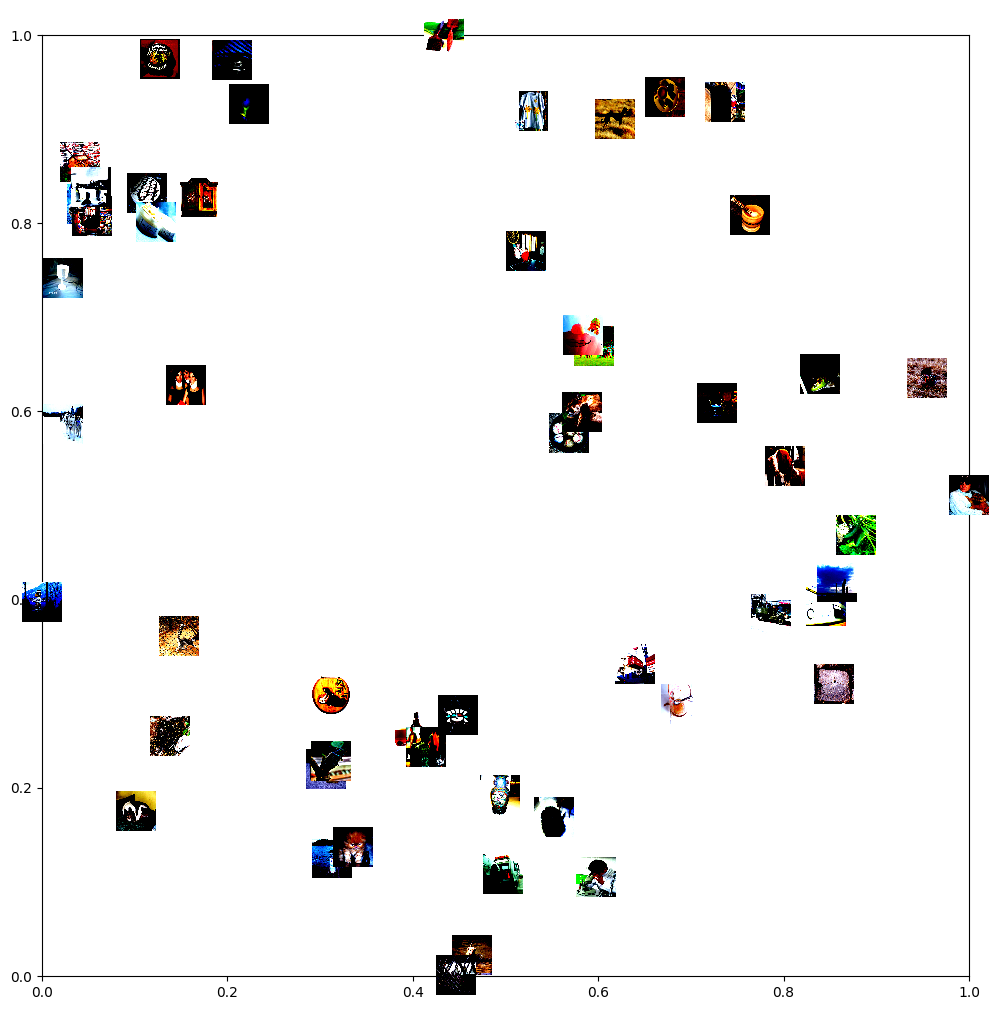

73 images in OPT cluster 1
50000
[35 25 55 23 42 22  2  8 63 13 23 52 16 51 39 31 17 61 11 24 53 37 52 43
 12 20 14 32 47 47 40 61 33 49 55  7 56 61 42 44 34 50 32 28 12 50  4 11
 34 38 33 12 19  5 14 25 50 19  0 15 46 18 27 32 53 24  4 45  3 14 42 20
 50] [ 1251  2137  2167  2327  2538  2710  3010  3080  3455  3917  4247  4980
  5008  6707  6759  7327  7569  8317  8651 10392 10549 10853 11764 12267
 13068 14036 14798 15264 15919 16303 17384 17597 18657 18673 19511 19527
 20088 21437 22314 23404 23522 23730 24160 24284 24780 24946 24964 25675
 25762 26278 26401 26636 26899 27717 28558 29785 31154 32147 33408 34703
 34990 36114 36251 37920 38389 38872 39492 39533 39875 40462 41706 44692
 44978]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

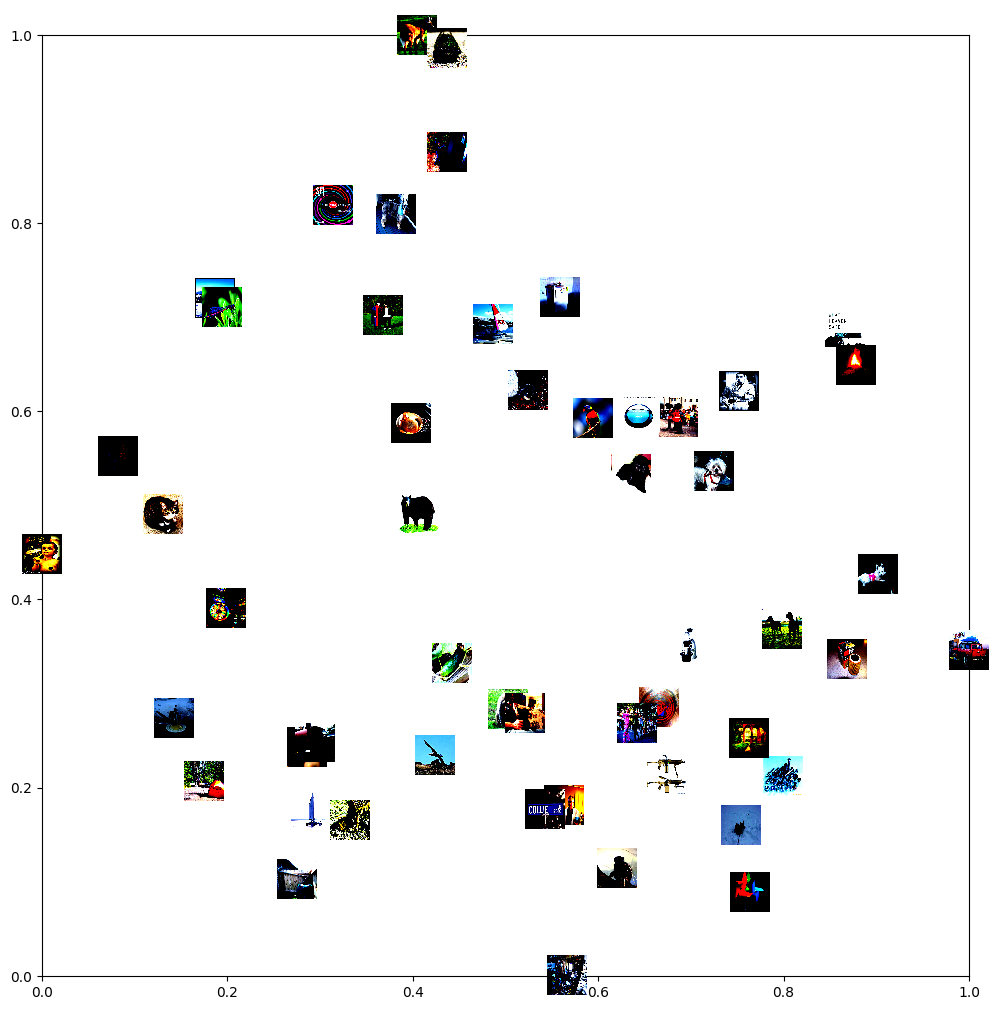

67 images in OPT cluster 3
50000
[35 56 13 44 37 37 23 57 10 40 11 21  4 24 58 45 29 58 13 29 62 37  1 47
 53 44 40 59 21 31 12  2 60 18  9 26 17 62 10 20 17 31 35 56 40 62 63  3
 21 38 37 23 30 60 53 50 40 24  6 45 25 15 23 22 54 28 28] [  163   440   717  2156  2277  2853  3479  5241  6090  7144  7243  7381
  7620  7704  7738  9325 10205 10362 11085 11229 11710 13285 13313 13615
 15029 15084 15400 15611 16085 18719 19916 20354 20412 20754 21001 21146
 21585 21758 22026 22292 22737 22751 23203 23480 25576 25982 26943 28035
 28821 30054 32421 32855 34334 34364 35061 36338 36456 36696 37126 37613
 38809 39823 42135 42198 42422 42844 44636]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

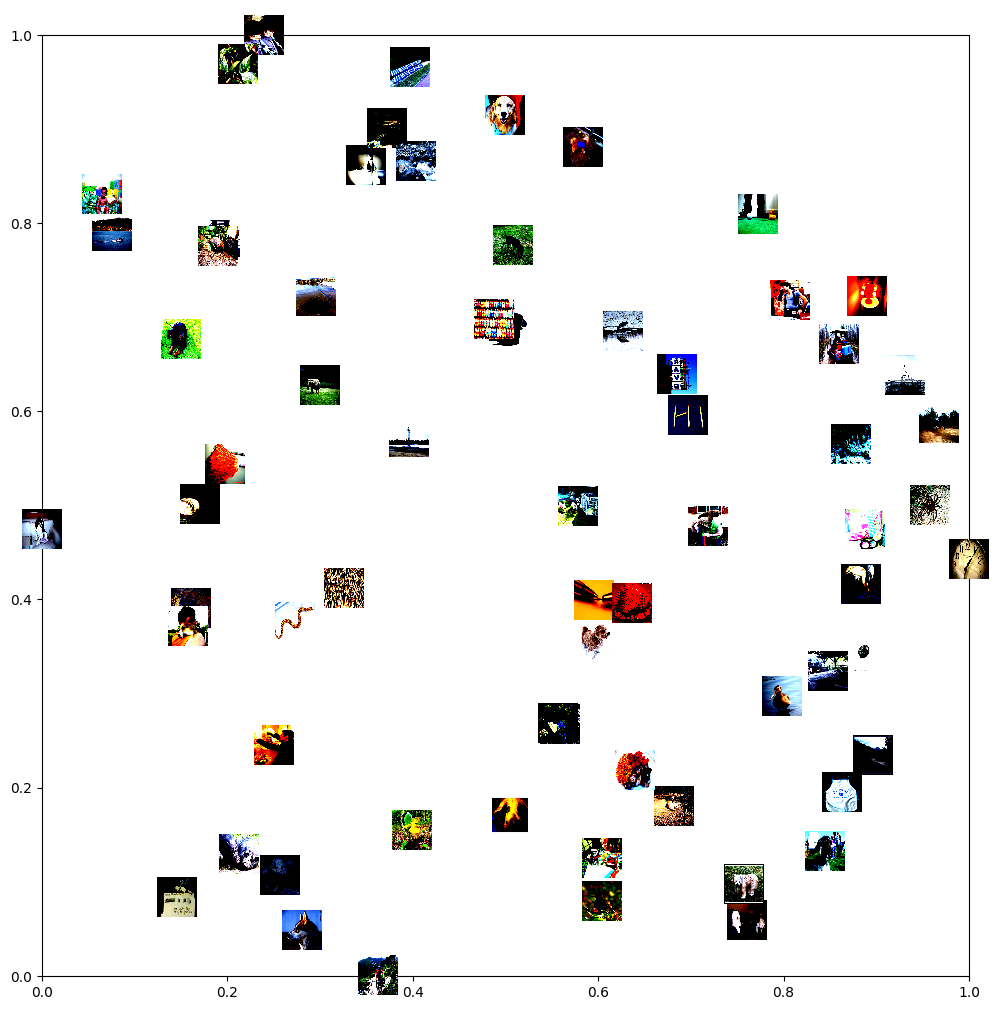

65 images in OPT cluster 4
50000
[56 56 16 31 51 41 16  4 46 31 49  6 38 48 46 45 62 35 28 37 11 39 11 48
 50 39 61  1 14  6 61 51 48  4 54 13 21 12 15 42 59  9 28 47 11 35 48 46
 17 12 44 10  2 37 40 59  1 13 47 32  6 60 28 62 44] [ 2424  2552  3024  3103  3571  6825  6992  7044  8046  8287  9393  9734
 10086 10096 11118 13293 14398 15523 15772 17381 17739 17767 18251 18544
 19186 20199 20669 21121 21134 21510 23869 24499 24624 25348 27958 28237
 28309 29260 30031 30442 32059 34569 34716 35759 35915 36003 36144 36334
 37009 37196 37676 37962 38722 38757 38760 39355 39873 40717 40879 42080
 42118 42620 44060 44222 44524]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

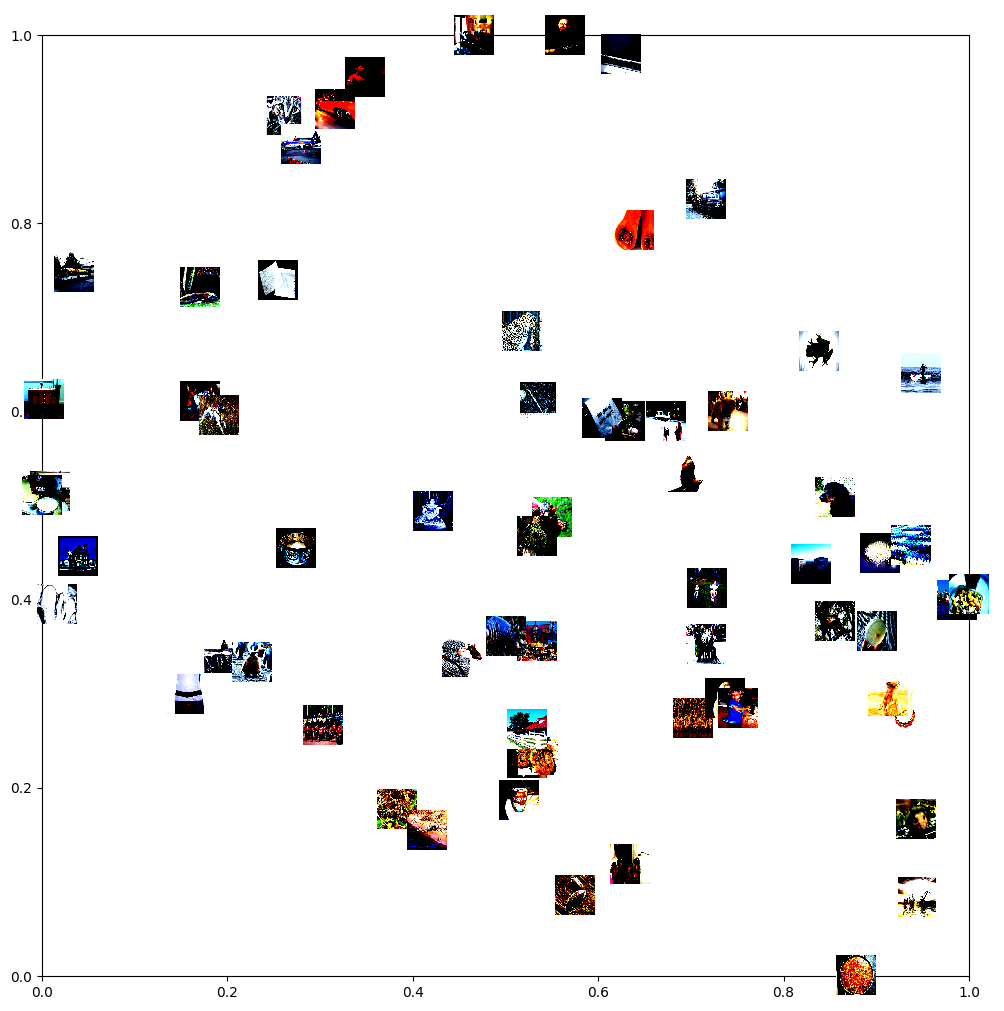

66 images in OPT cluster 5
50000
[ 5 63 39  8 34 20 28 13 49  7 43 59 17  3 27 41 51 48 50 60 57 10 14 21
 26 11  8 26 56 59 10 20 22 19 10 19  9  8  9 30 31 28  6 44 24 51 36 57
 15 59 44 13 37 23 22 21  1 12 28 54 45 49 48 51 18 47] [ 1861  2047  2407  4872  5218  5460  6684  7117  7473  7495  9707 10043
 10129 11203 12187 12265 12915 14768 15538 15740 17529 17930 17998 18517
 18586 19019 19848 19994 21176 21435 23562 23764 24086 24723 25226 25619
 27785 27848 28681 28766 29023 29084 31193 31404 32280 32307 32548 32569
 33807 34747 34988 35533 36453 37143 39126 39957 40193 40524 40988 41014
 41133 41649 42096 42163 43474 43695]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

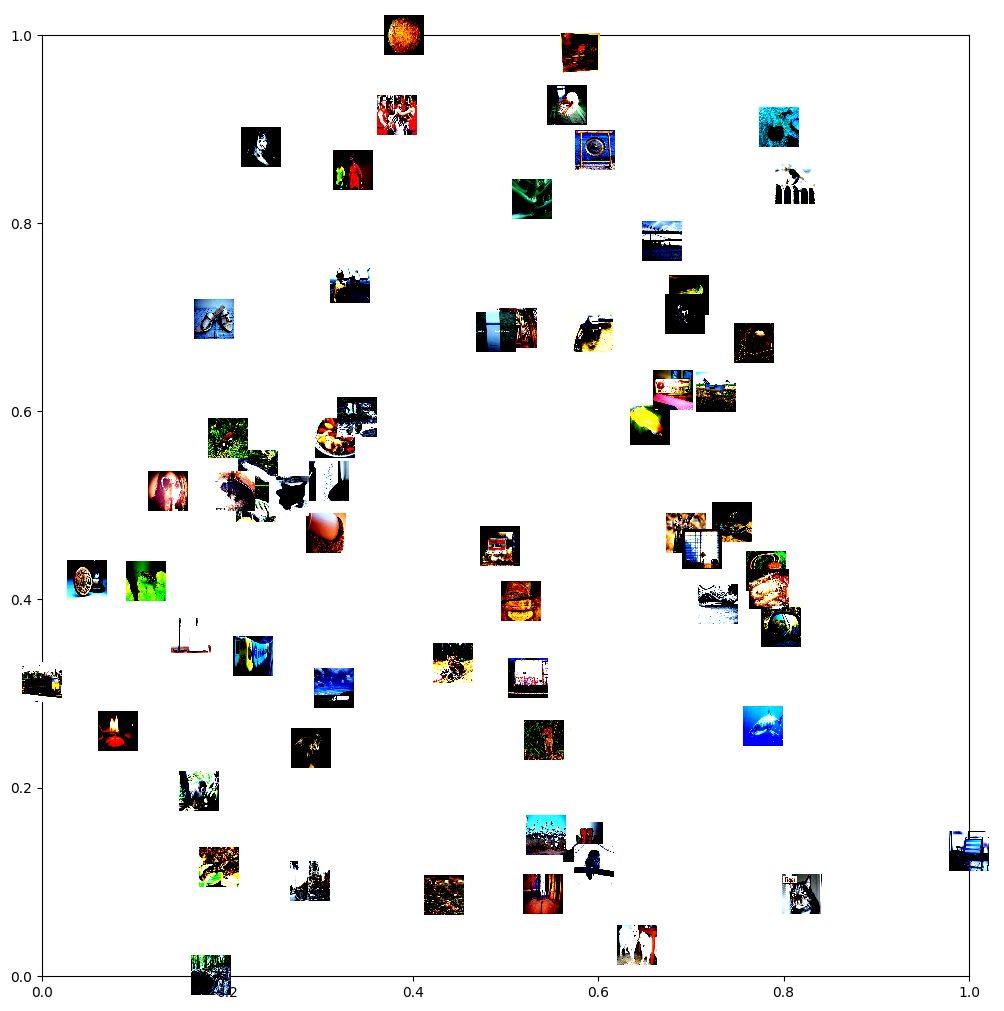

78 images in OPT cluster 6
50000
[38 51 36 29  2 35 33 22 50 13 59 56  0 11  7 37  6 11 45 58 22 54 56 10
 53 26 33 21  2 54 16  9 53 38 25 12 13 46 62 46 18 27 10 63 44 29 37 45
 61 10 41  3  4 58 60 51 22 49 40 19  2  7  9 59 29 20 14 38  6 40 63 41
 50 61 35 34 56 20] [  230   307   804   989  1154  2851  2977  3094  3378  3405  3451  3576
  3648  3787  4231  4709  4870  5387  5485  5882  5910  6198  6840  7050
  7733  8026  9121 10453 11010 11190 11664 12425 13109 13798 14617 14796
 14989 15598 18622 18734 18770 19867 20874 21439 21676 22813 23077 23597
 24189 24650 26537 26627 27396 28730 28860 29299 29462 30065 30568 31635
 32642 33159 34249 34299 34333 35604 36046 36326 36870 37352 38207 38825
 39474 39741 40163 40610 41656 41748]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


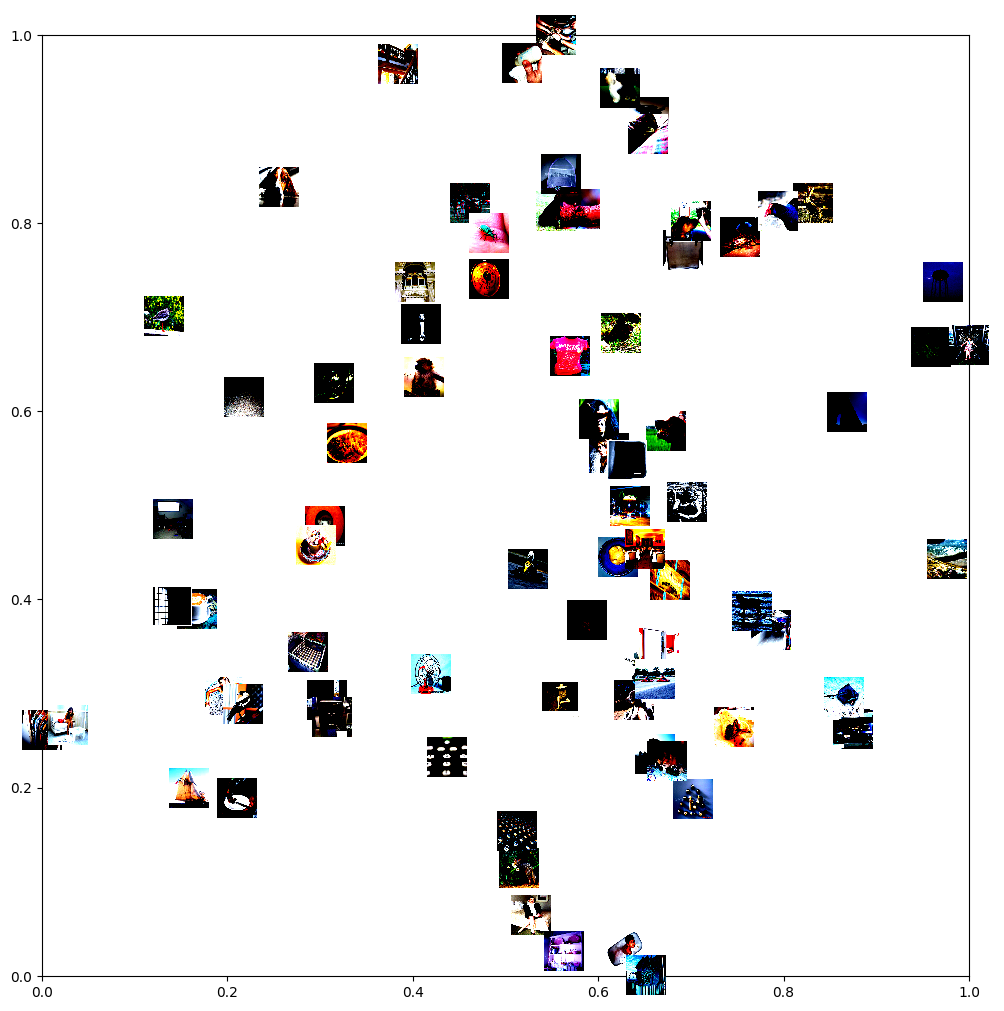

39 images in OPT cluster 7
50000
[46 31 58 37 19 53 28 17 54 40 19 49  4 30 38  6 14 23 26 61 52 27 59 16
 63 31 55 17 38 48 35 46 12 39 25 14 19 28 55] [ 1070  2847  2874  3045  4243  4277  6492 10065 10998 13288 13843 15537
 16836 18654 18726 20614 21006 22871 25754 26941 27636 27995 28731 29648
 30719 31455 31543 33041 33190 33392 35555 35694 35852 37159 40217 41614
 43283 43996 44791]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

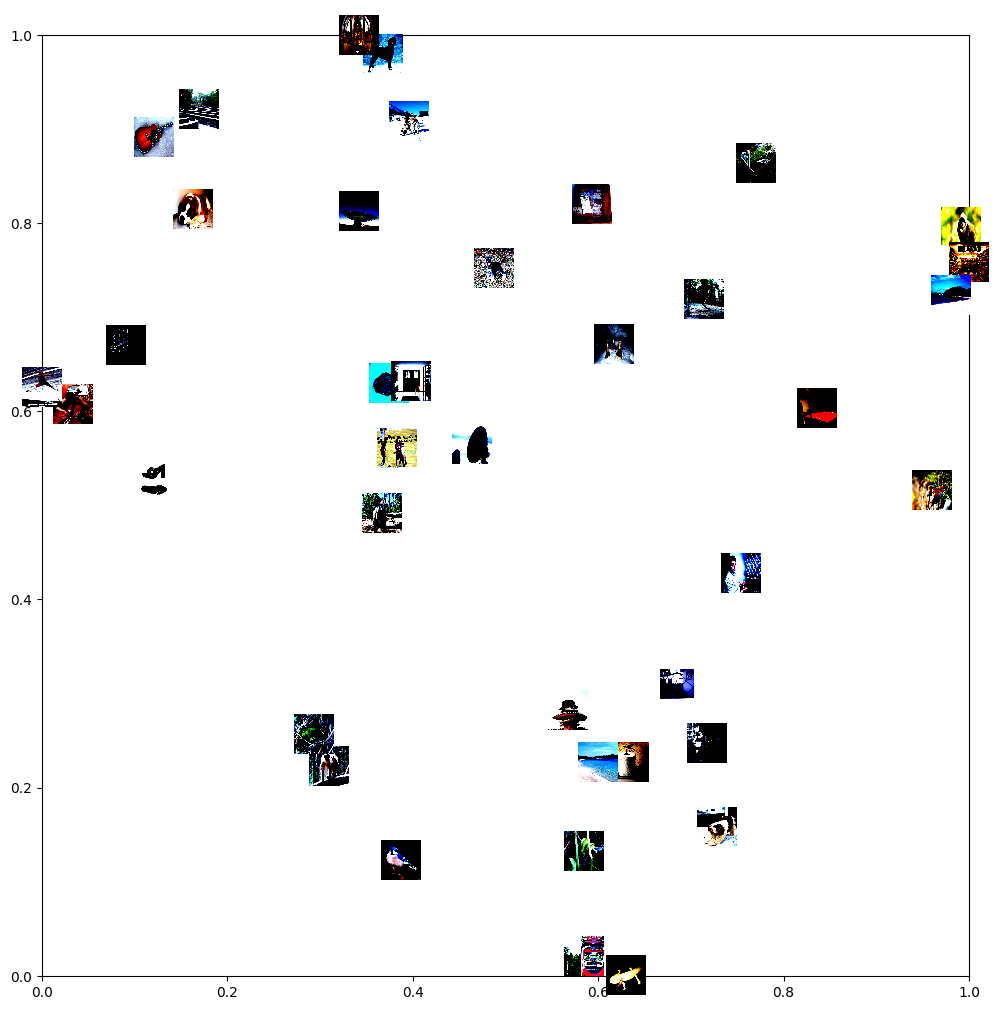

51 images in OPT cluster 8
50000
[61 29 17 23  7 58 48 38 54 23 33 37 36 33 43  0 13 42 47 33 42  4 13 34
 47 44  8 17 23 54 40 26 47 27 24 26 26 63  0 42 49 57 30 49 48  2 36 63
 17 32 46] [   61  3101  3217  4055  5511  6074  6384  6822  7478  7511  8545  9957
 10916 12321 12523 13568 14093 14378 16623 16673 16874 17412 18829 19170
 19503 21100 21384 21649 21783 22518 29672 29722 30319 30683 31192 31194
 31706 31807 32832 34602 35313 36729 37214 37233 38000 38466 39716 41855
 42705 42720 44782]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

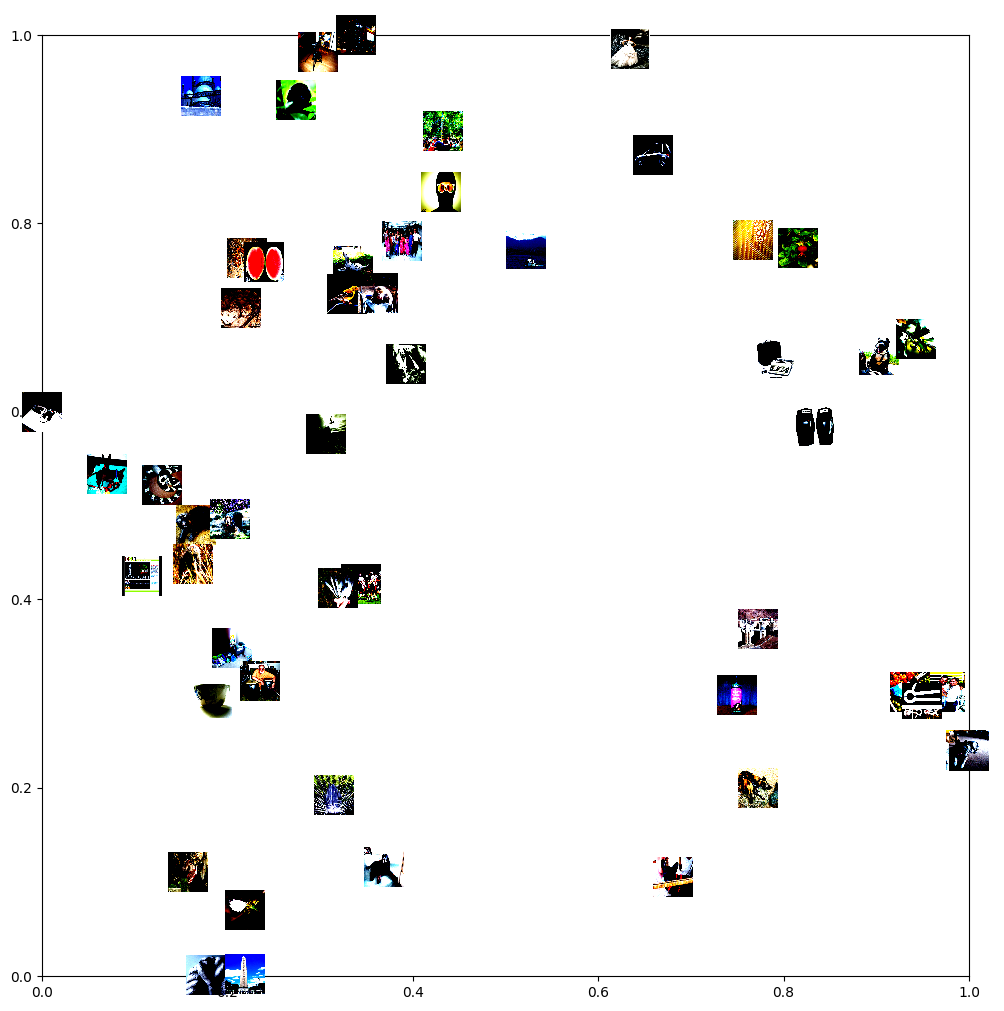

40 images in OPT cluster 9
50000
[28 17 23 16 30 56 26 12 44 51 49 62  4 62 14 28 10 17 22 12  4 27 50 35
  7  6 23 50 63 61 21  3 17  2 13 55  8 10 33 17] [ 3228  5457  6423  6480  6686  7864  7962  8588 10924 10931 12721 15998
 18564 19582 19982 20892 21386 21521 22230 24140 24260 24283 25778 27939
 28615 28806 29271 30130 30207 31357 31381 32451 32593 33602 35341 36599
 43080 43530 43809 43985]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

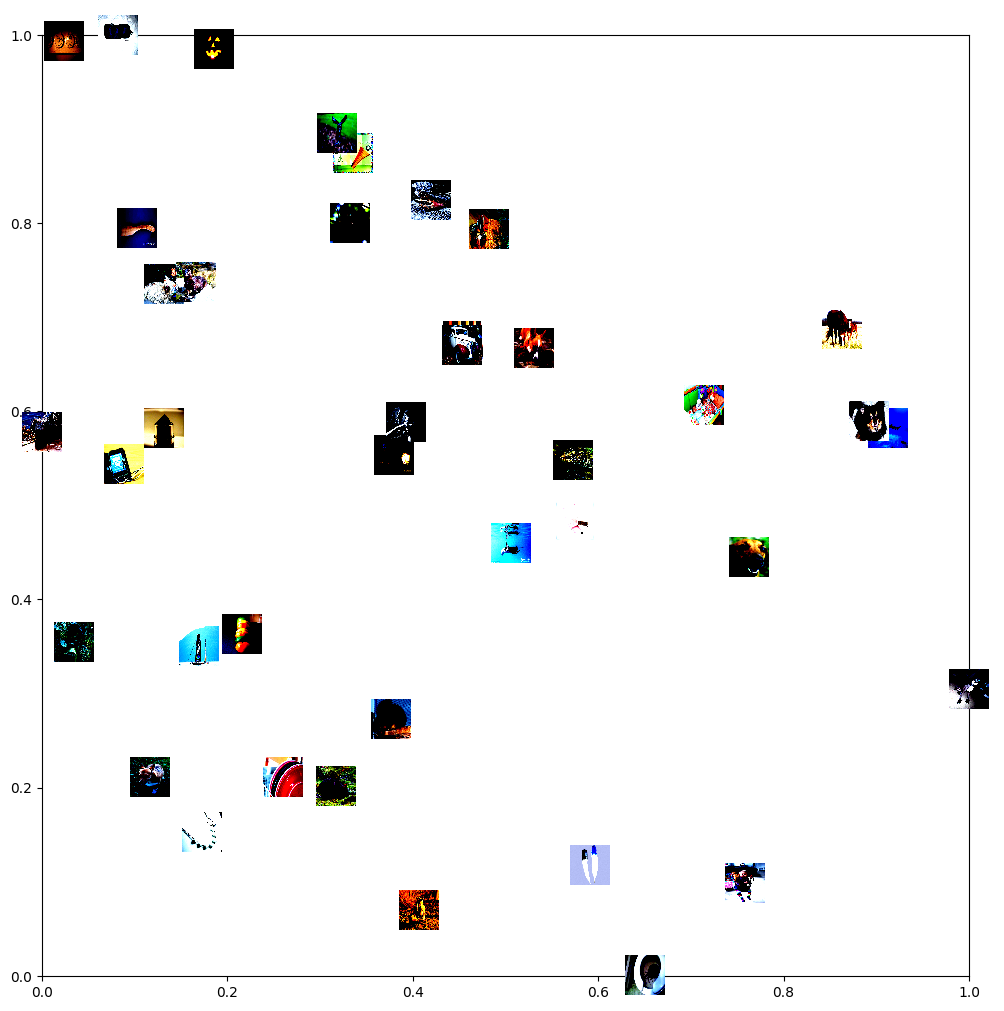

30 images in OPT cluster 10
50000
[12 14 49 23 59  4 54 46 34 36 50 58 39 60 37  2  3 24 55  5 35 56  7  8
 60 39  6 47  8  4] [ 1356  3790  5297  6359 14267 14980 15862 15982 16546 16804 17778 20666
 21223 21692 23141 24258 24771 25944 26935 27205 28707 33464 34887 35592
 39676 40679 41414 44143 44296 44804]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

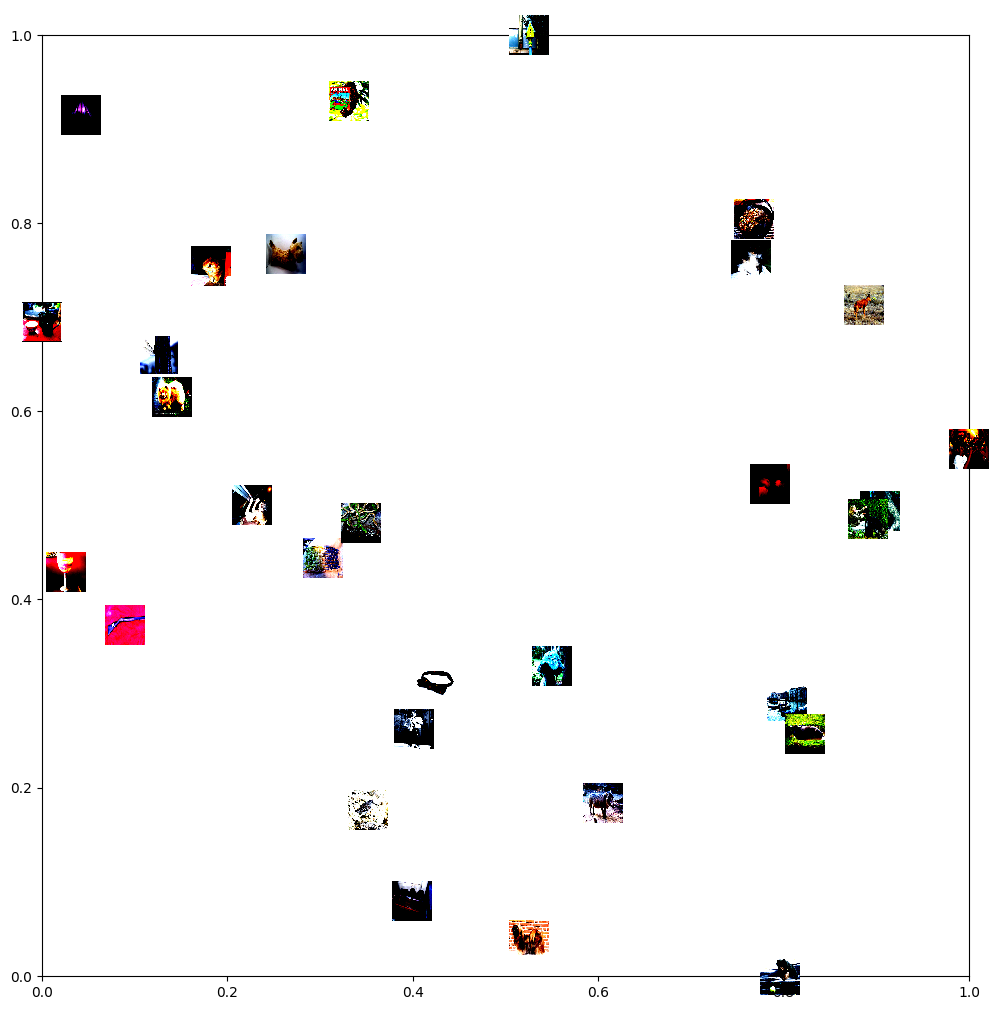

43 images in OPT cluster 11
50000
[58  8  1 41 30 60 46 49 35 12 56 46  3  4 11 13 53 41 55 60 57  8 18 19
 23  9 32 47 11 34 19  3 11 14 17 60 43 39 36 58 37 17 33] [  442  1800  1921  1961  2398  4732  5806  6001  6115  6348  6392  7086
  7875  8068  9675 11021 14453 14569 15607 16060 16569 17992 21074 22419
 22935 23433 24480 25199 26827 26914 27091 29763 33163 33870 38865 39164
 39531 39719 41060 41338 42149 43025 43937]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

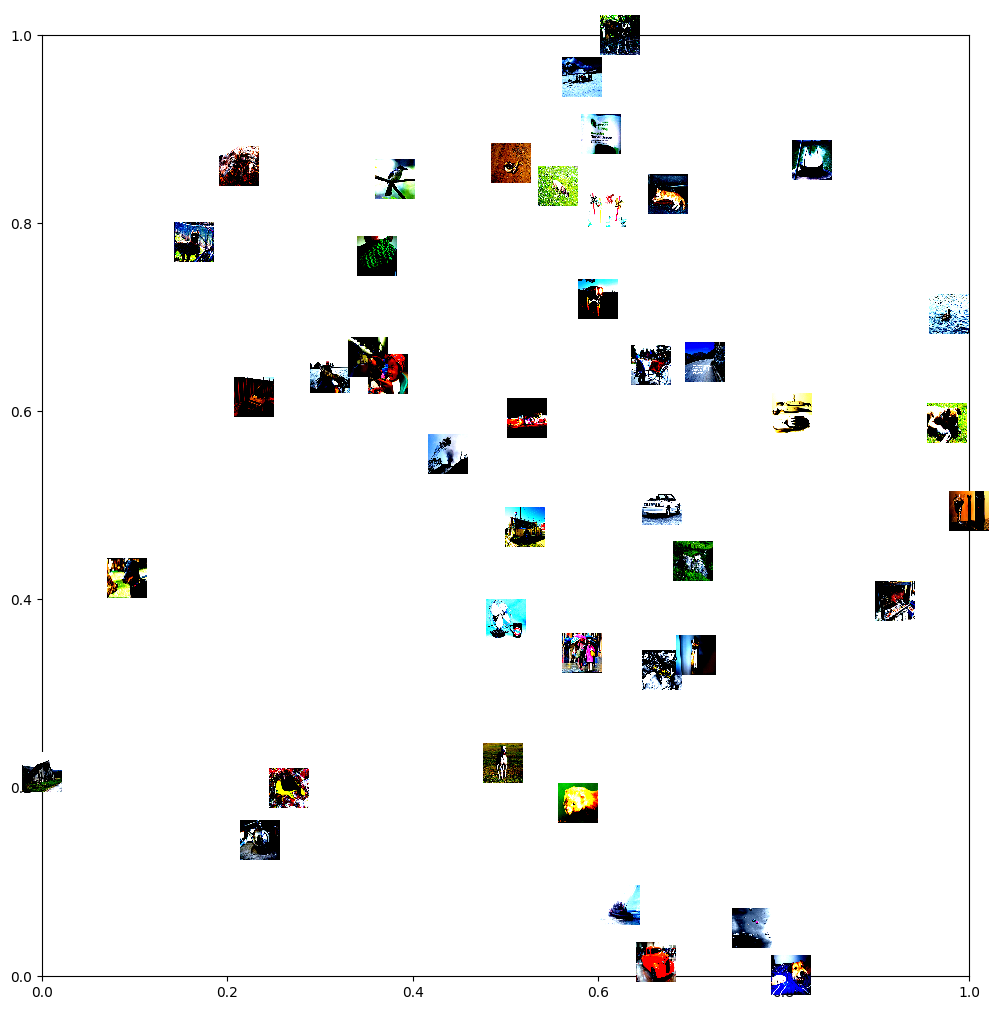

41 images in OPT cluster 12
50000
[61 10 57  3 24 25 62 10 38 26  0 37 52 30 61 11 24 29 14 12  9 44 62 44
  3 22 13  3 57 24  4 18  0  5 60  6  4 34 63 17 51] [ 3133  4554  6201  6659  6808  9753 10494 10634 10662 12058 12352 14565
 16884 18526 20541 21067 21208 22109 23310 24268 25097 25516 25918 27244
 28867 32022 32397 35075 35449 38232 38276 39314 39680 42053 42300 42758
 43332 43618 43647 44817 44915]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

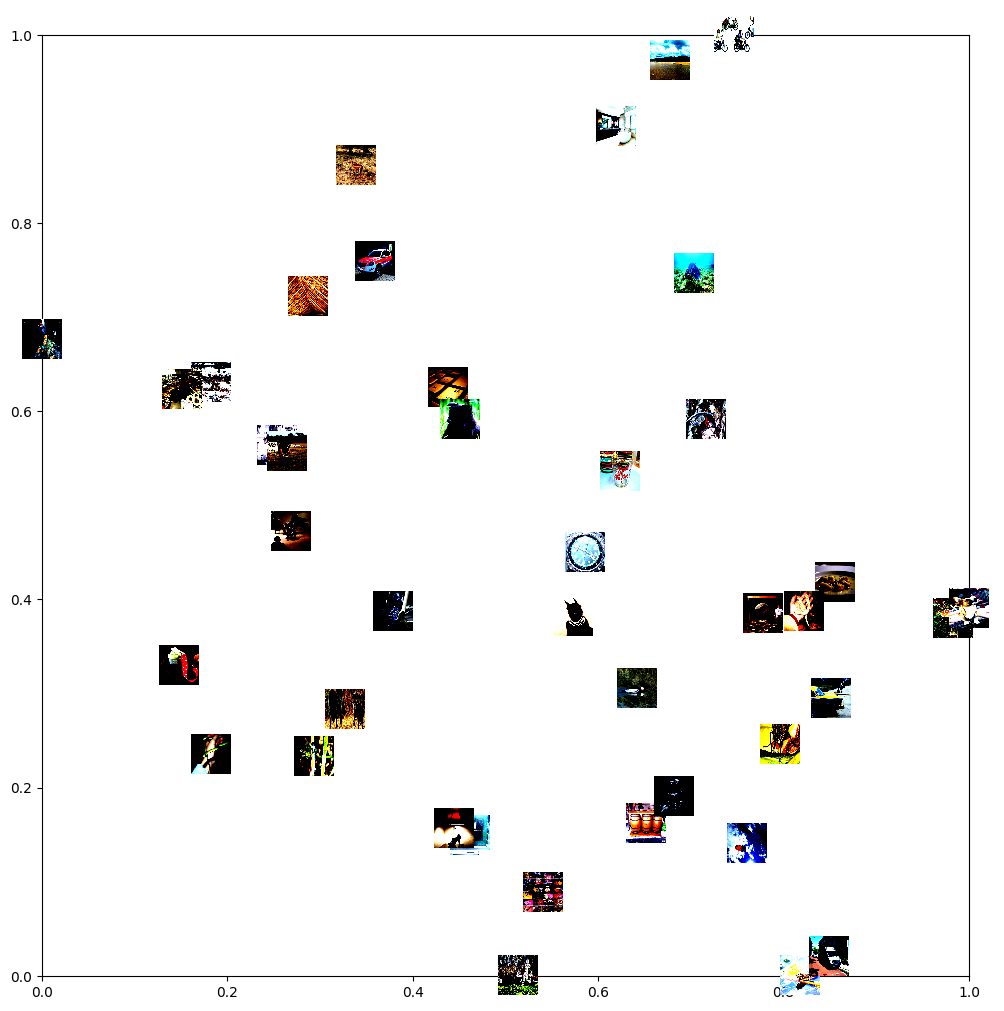

55 images in OPT cluster 13
50000
[22 36 46 21 10 33 40 49 58 11  8 63 63 49 55 10 45 12 22 21 24 60 48 56
 63 43  7 20 36 35 19 61 45  2 46 12 27 44 63 10 16 13 21 33 20 57 17 54
 36 47  1 28  0  6  6] [ 1238  2276  2478  2645  3722  5985  7592  7729  9146  9803  9864 10559
 11903 12145 13751 14218 15789 15948 16278 17237 17432 17852 17968 18360
 18559 19115 19335 19860 20196 20707 21459 21501 21933 23042 23214 24716
 26971 27756 29951 31178 31184 33805 35029 35425 37012 39033 39889 40182
 40932 41711 42305 42780 43520 43910 44806]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

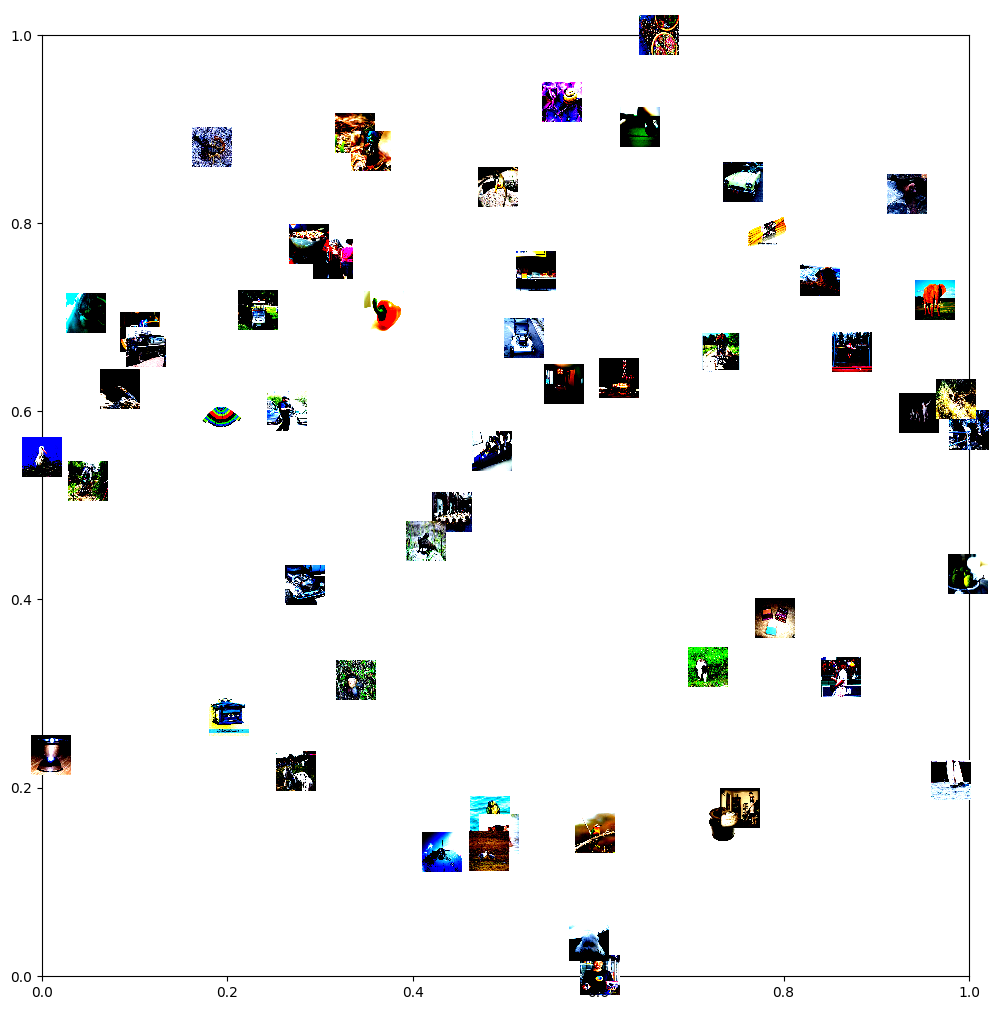

73 images in OPT cluster 14
50000
[22 50 53  5 57 37  0 36 24 22 53 58 62 21  1  3  5 52 63 23 37 60 29 21
 18 40  2 22 47 55 19 11 17 61 12 12 12 37 47 29 17  4 22 20  4 39 35 24
 62 17  1 60 53 53 36 21  3 47 27 28 35 32 29 18  8 40 15 42 48  0 49 55
 57] [  150   306  1333  1477  2937  3429  3584  3684  4376  5014  5173  7354
  7742  8533  8705  8771  9029  9396  9727 10007 10917 10940 11101 11477
 13010 14888 15170 15766 17647 18935 20371 24395 24977 25277 25484 25932
 26508 27045 27247 27357 27665 27716 27798 28052 28740 29031 29219 29464
 30910 31185 31425 31868 32053 32565 32804 32917 33155 33327 33563 33564
 33891 35744 36253 36306 36552 36904 37711 38826 41712 42304 43825 44023
 44409]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


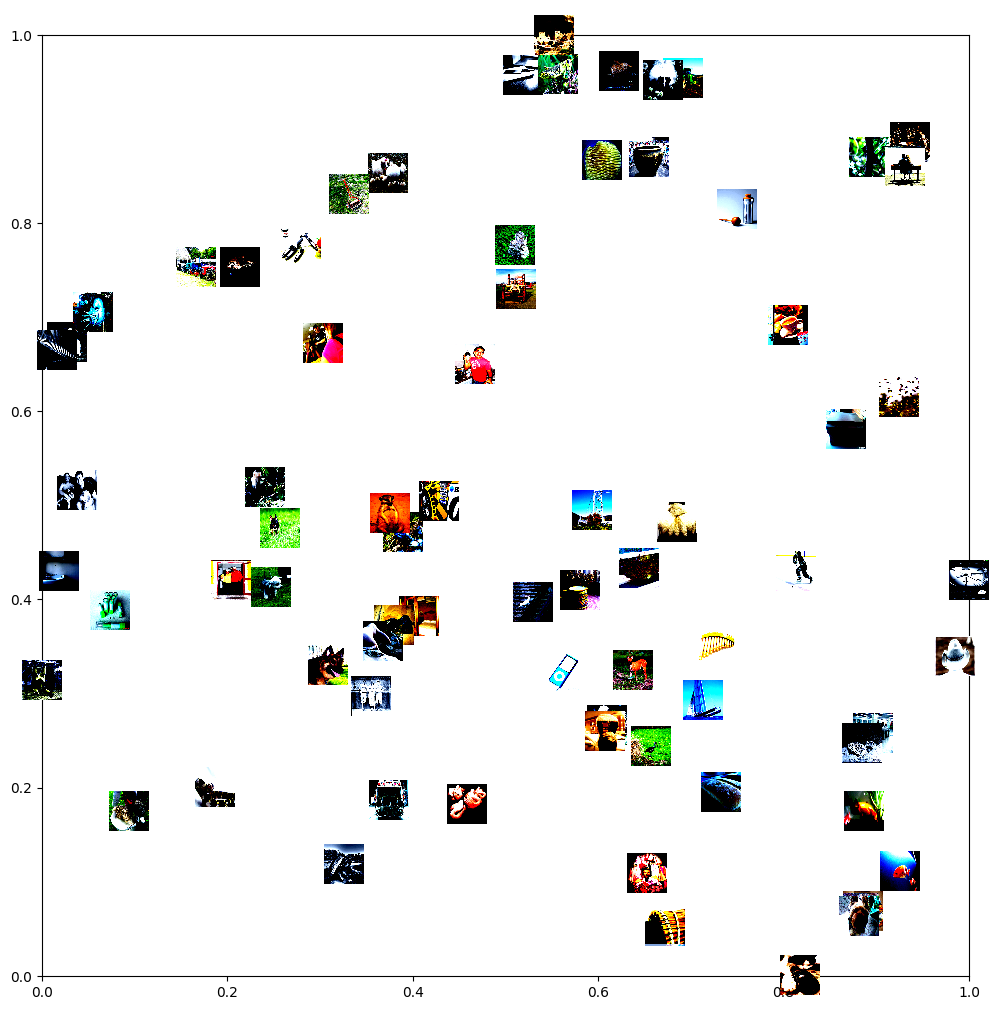

9 images in OPT cluster 15
50000
[28  1 17  1 24 32 63  0 42] [ 5788  6465 13905 17665 17752 18976 35199 38720 43178]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

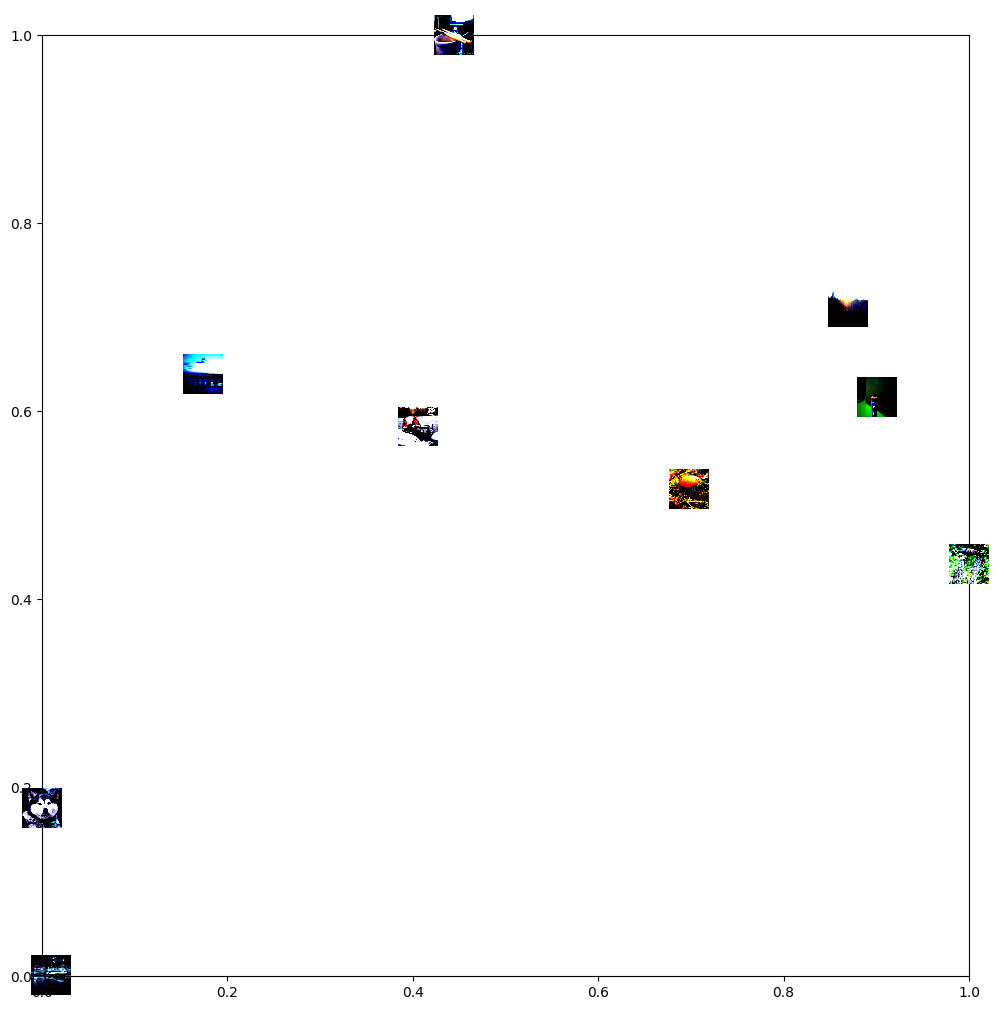

55 images in OPT cluster 16
50000
[45 11 20 63  3 28 39 40 16  1  6  7 41 49 14 36 44  6 39 44 22  1 31 46
 55 24 61 34 34 42 27 52 48 20 27 46 53 13 14  0 43  5 62 38 15 24  8 22
 14  9 26 43 33 52 55] [  429   843   980  1023  2755  2908  3879  4904  6608  6721  8134  9095
  9513 10353 11790 12196 12268 12358 13799 14124 14486 15553 16159 18094
 20151 22680 22909 23586 24674 25642 26011 27508 29296 29652 30107 31342
 32629 32717 32846 33280 33451 33989 34110 34406 34895 35160 36616 38294
 38862 39305 39642 41259 42337 44980 44983]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

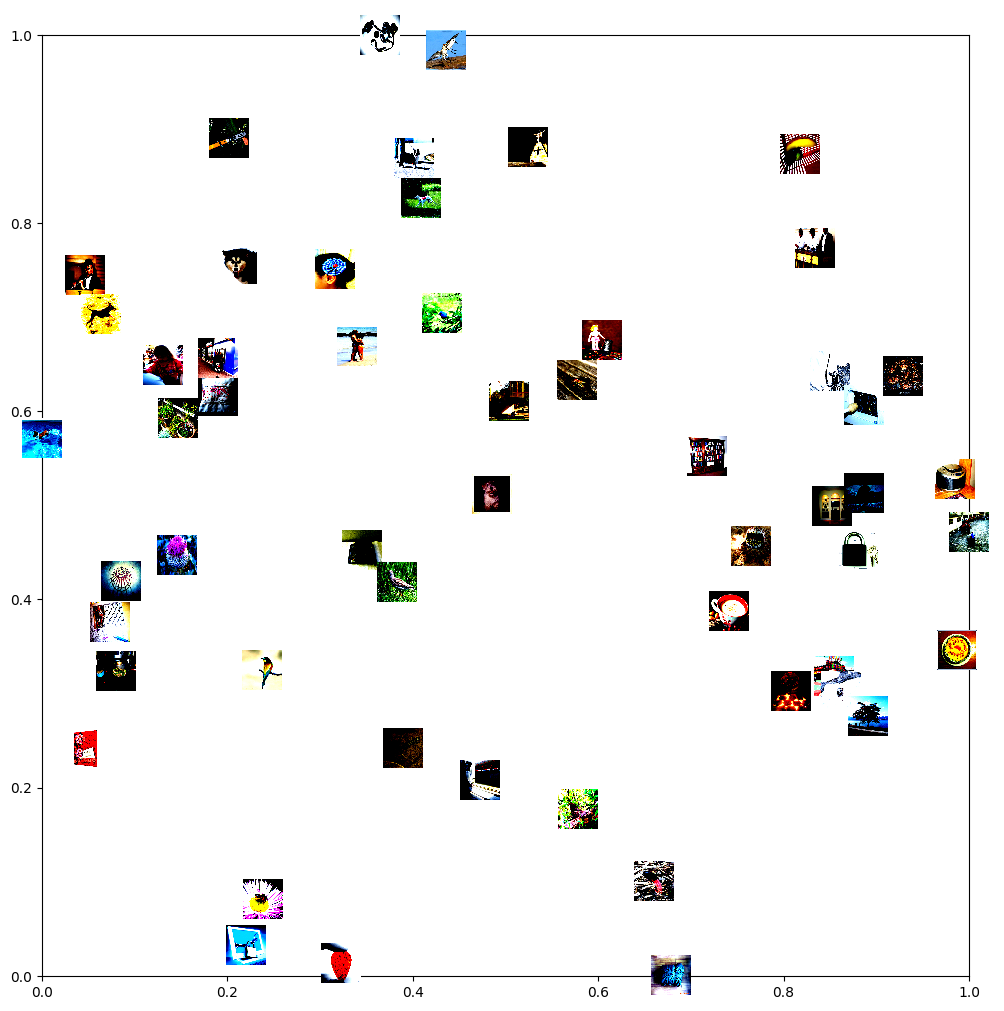

20 images in OPT cluster 17
50000
[ 5 37 46 32 38 61  9 61 45 12  4 46 52 56 40 37 42 28 19 56] [ 4165  5541  9390 11808 13606 15421 16265 17085 18221 19020 20228 26286
 28148 30520 32680 33637 35882 40860 40979 43320]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

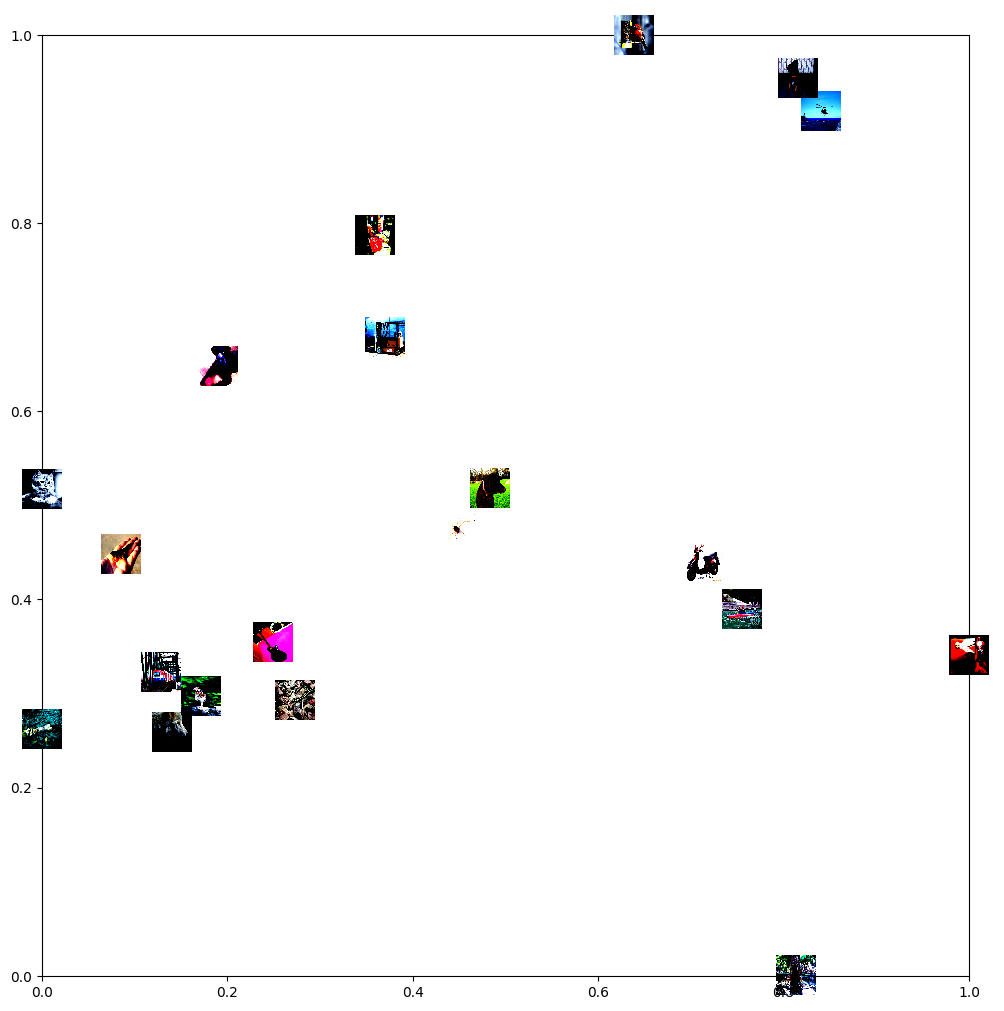

58 images in OPT cluster 18
50000
[47 26 29 46  7 51 41 16 63 51 49 17 25  2 63 43 40 26 52  5 10 46 48 19
 21  2  8 37 57  5 23 33 41 54 40 28  5 24  7 15 14 35  3 32 31  4 25  8
 48 46 48 25  1 52  7  1  6 17] [  367   410   797  1198  1223  1331  1577  1616  2175  2995  3121  5009
  5273  5634  6143  7275  7464  7834  8756  9221 10762 10798 12016 13779
 14997 15490 15752 16293 17401 17797 18327 20001 22569 22710 23144 24028
 24453 24600 25287 27087 27342 27683 27907 28640 29407 30276 32345 33160
 34352 34606 35440 36569 36737 37300 37383 38017 38406 41617]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

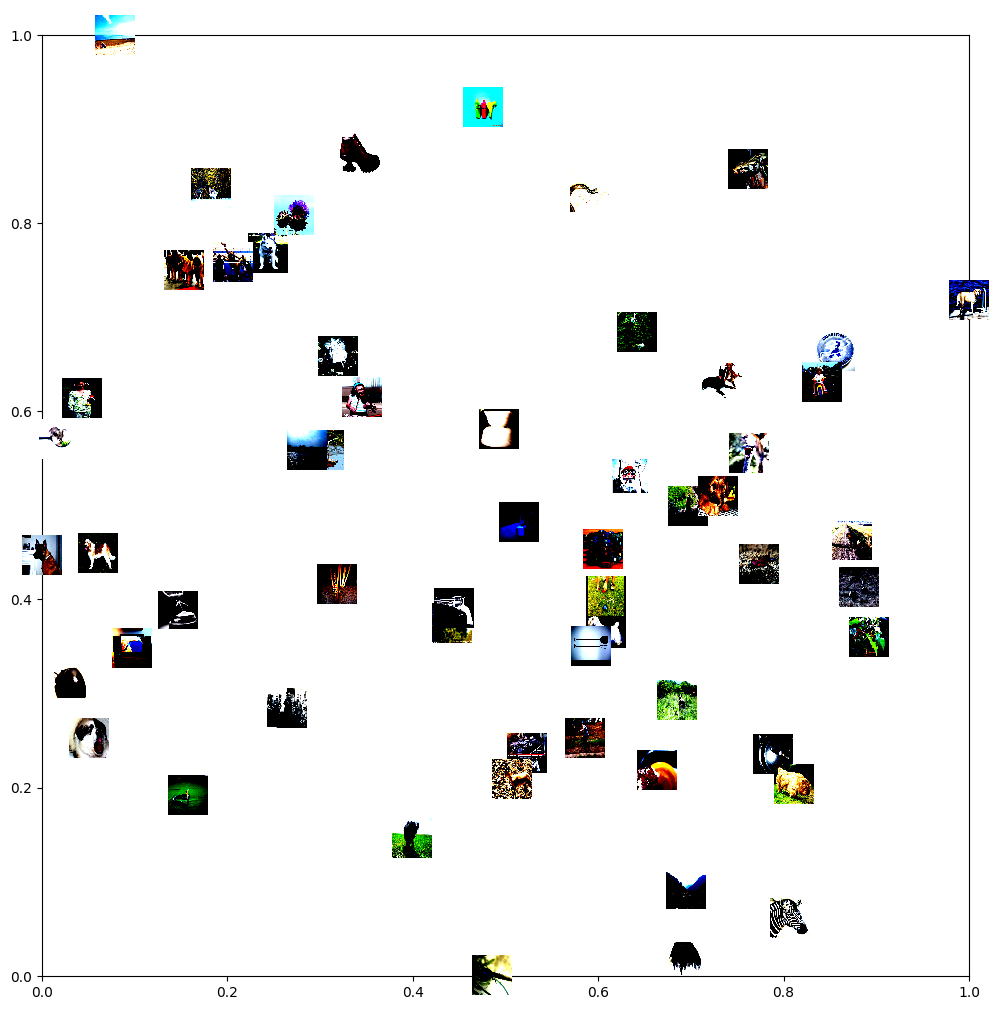

54 images in OPT cluster 19
50000
[36 62 62 52 56 29 37 21 28 54 41 51 18 41 26 32  2  8 61  5  7  9 62 26
 58 42 12 42 51 50 19 28 38 63 62 63 21 34 28 24 55 31 35  0 38  7 57 22
 18 44 28 10 36 52] [  100  1598  1918  2036  4728  5789  5797  6677  8284 12470 12969 13171
 14354 15209 15258 15328 16066 16520 17021 17349 18439 20937 23486 23834
 24186 24874 26764 27562 27891 28274 28947 30236 30310 30911 30974 31103
 31829 32354 32732 32792 33143 33183 35235 35712 35942 37447 37753 38870
 40402 41196 41756 43722 44708 44788]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

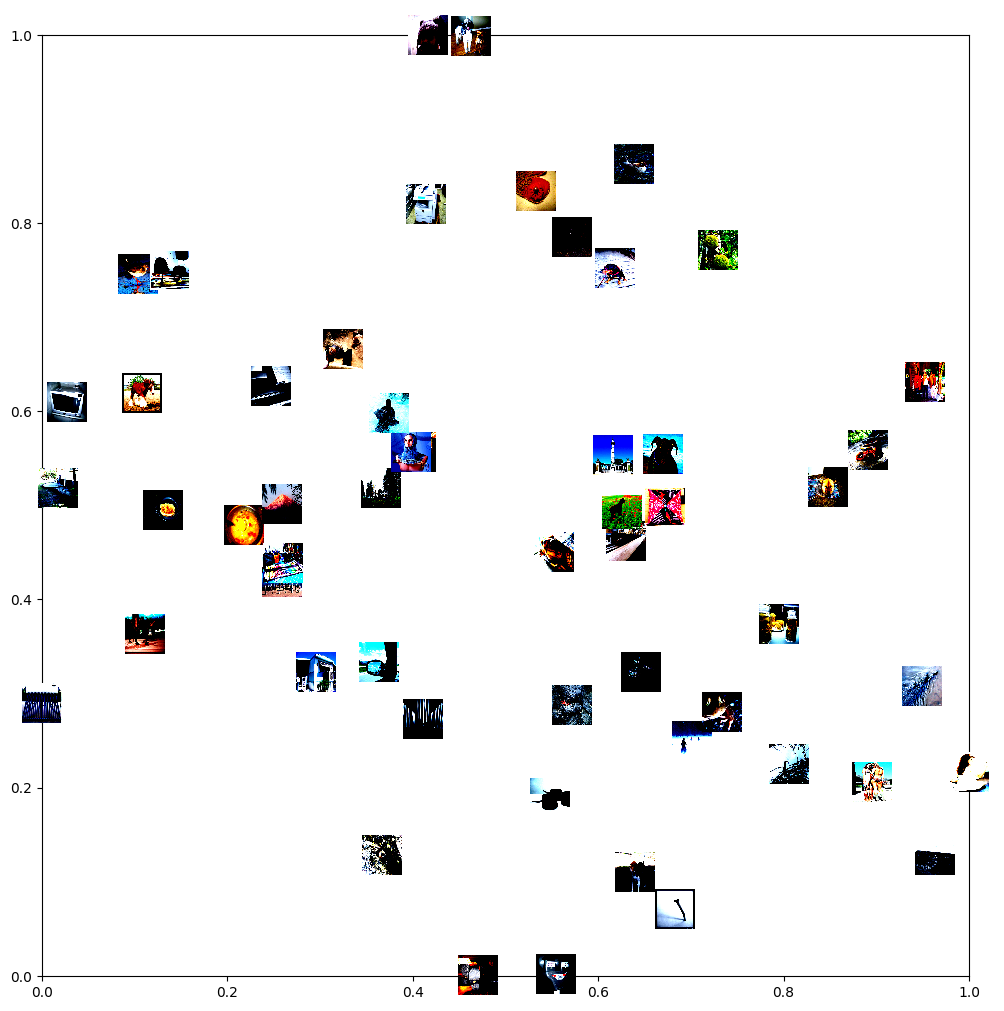

67 images in OPT cluster 20
50000
[37  1 10 48 32 50 45 16 43 26 40 43  0 16 44 51 42 21  0 21  5 49 19 11
 51 44 29 59  6  2 53 36 37 54 42 34 62 36 54 32 29 46 30 23  3  8 43 44
 53 31 11 45  4 45 36  0 25 45 59 53 39 28 40 24 13 13 17] [  165   449   458  1392  1568  1586  1773  3344  4331  4570  4968  5291
  8512  9360  9388  9971 10218 10325 11840 13077 13893 15409 16659 17163
 17395 17516 18141 18299 18438 19010 20725 22052 22117 22966 23082 24034
 24446 24996 25718 26464 26781 27182 29022 29143 30915 31304 33579 33644
 34485 35359 35403 35437 35972 36205 37988 38144 38425 39917 40891 41333
 41831 42012 42024 42136 42381 44301 44433]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

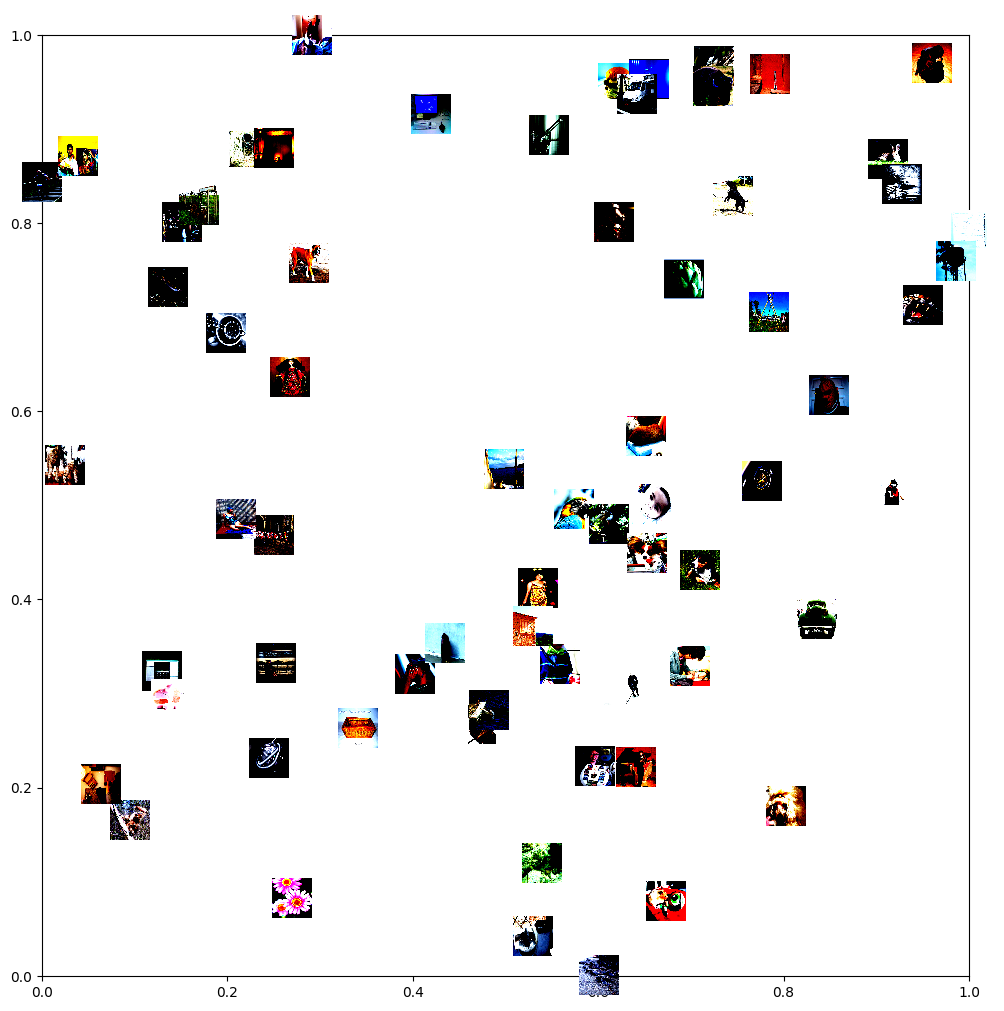

30 images in OPT cluster 21
50000
[28 46  1 21 12 28 21  3 61 25 37 47  1 31 34 14 34 26  9 50  0 59 24 46
 61 14 27 59 21 54] [ 1372  1518  2369  2901  2956  3868  6101  6915  8893  9625 14373 16943
 20481 20895 21410 21582 21986 22106 23113 24882 26240 27003 27736 32558
 34429 36686 37275 37691 38933 43894]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

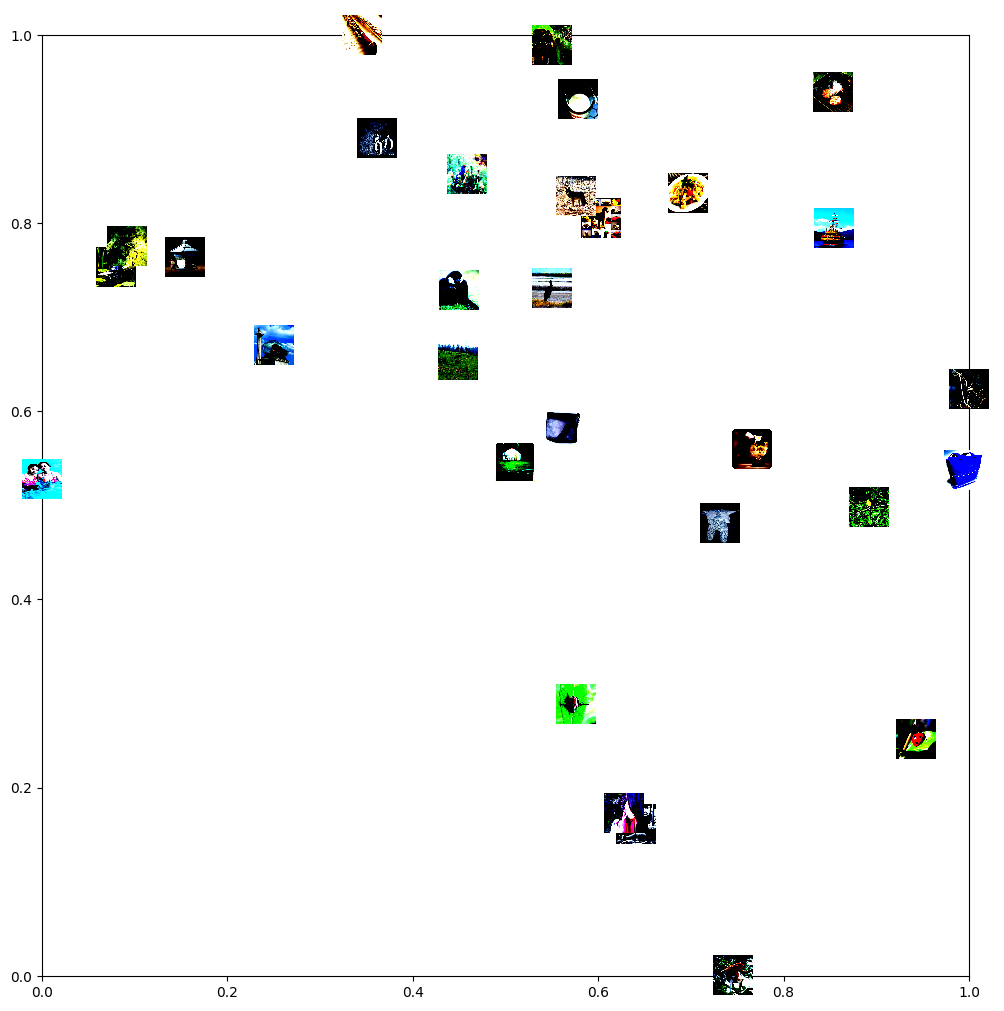

33 images in OPT cluster 22
50000
[30  6 39 62 46 17 43 61 52  7 29  1  5 32 32 42 61  3 15 41 15 49 40 44
 17 30 50 51 35  4 42 58 10] [ 3038  4678  4967  5118  6510 10833 12587 13501 13748 15111 15517 18625
 19397 21920 25696 25834 28541 29123 29199 29353 30671 31729 34344 34412
 35857 36190 36594 38067 39267 40388 41834 41978 42314]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

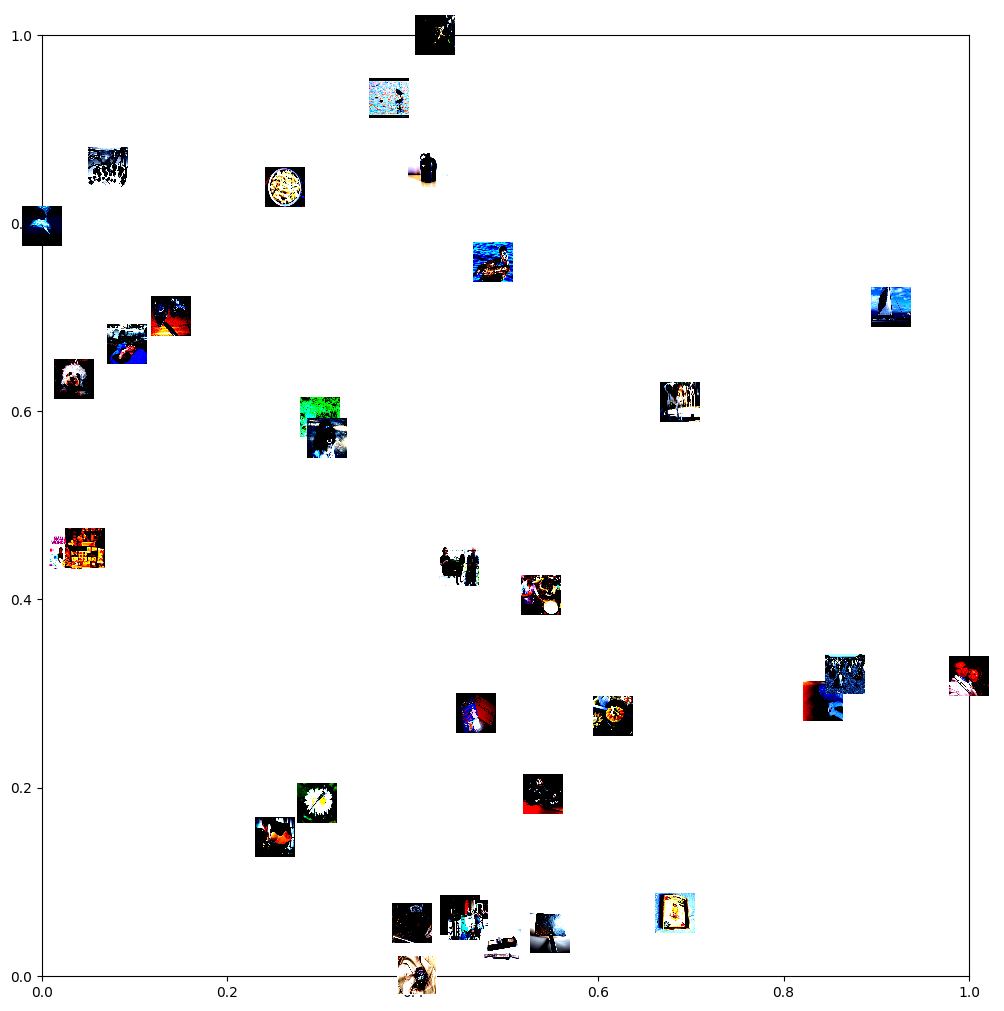

33 images in OPT cluster 23
50000
[50  9 51 14 56 31 25 20 32 38 28  5 29  0 29 54 13 41 29 40  4 61 48 24
 48 18 27 36 63 60 16 21 15] [ 3186  3337  4211  4878  6712  7903  8345  9940 10400 12262 14108 15109
 15453 15872 16285 16694 16909 18921 22301 22632 25476 26749 26928 27480
 29936 31506 36443 37924 38591 39228 40080 40725 42191]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

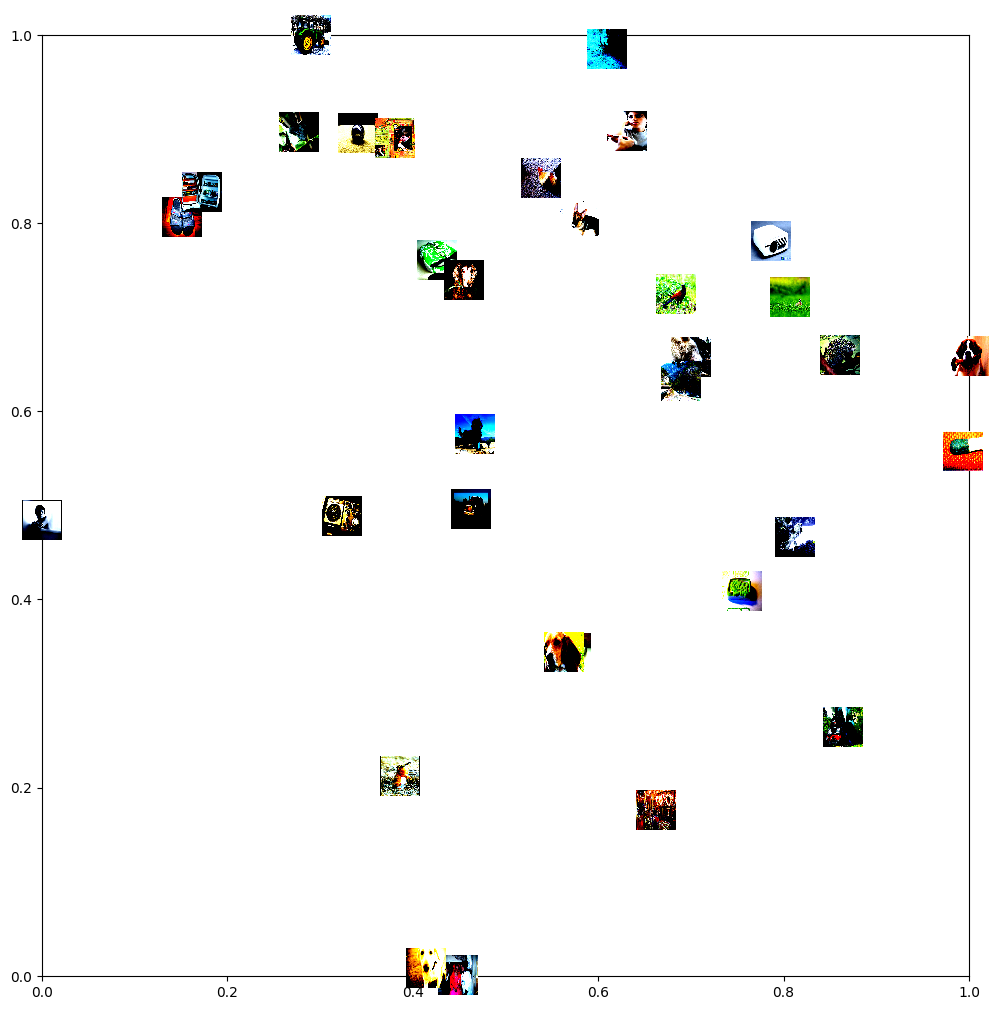

64 images in OPT cluster 24
50000
[31 54 45  1 39 36 17  9 22 60 25 46 61 12 26 58 55 63 13 30 37 62 61  9
 53 54 13 27 13 11 15 44 27 10  2 42 33 53 49 35 30 44  4 28  9 29 30  2
  3 54 32 42 63 47 30 44 45 61 12 49 50  6 14 41] [  863  1398  2157  2305  2663  2852  4177  4297  5782  6460  8089  8942
 10813 12172 12378 13434 13559 14015 14925 15518 16165 16446 16509 16969
 17653 19510 20045 21531 21773 22155 22287 23724 24411 24778 26178 26410
 26529 27637 28721 29475 29534 30124 31044 31388 31561 32285 32926 33282
 33475 34230 34400 34666 36607 36783 37470 38508 38509 38973 40652 41841
 42290 42694 43726 43881]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

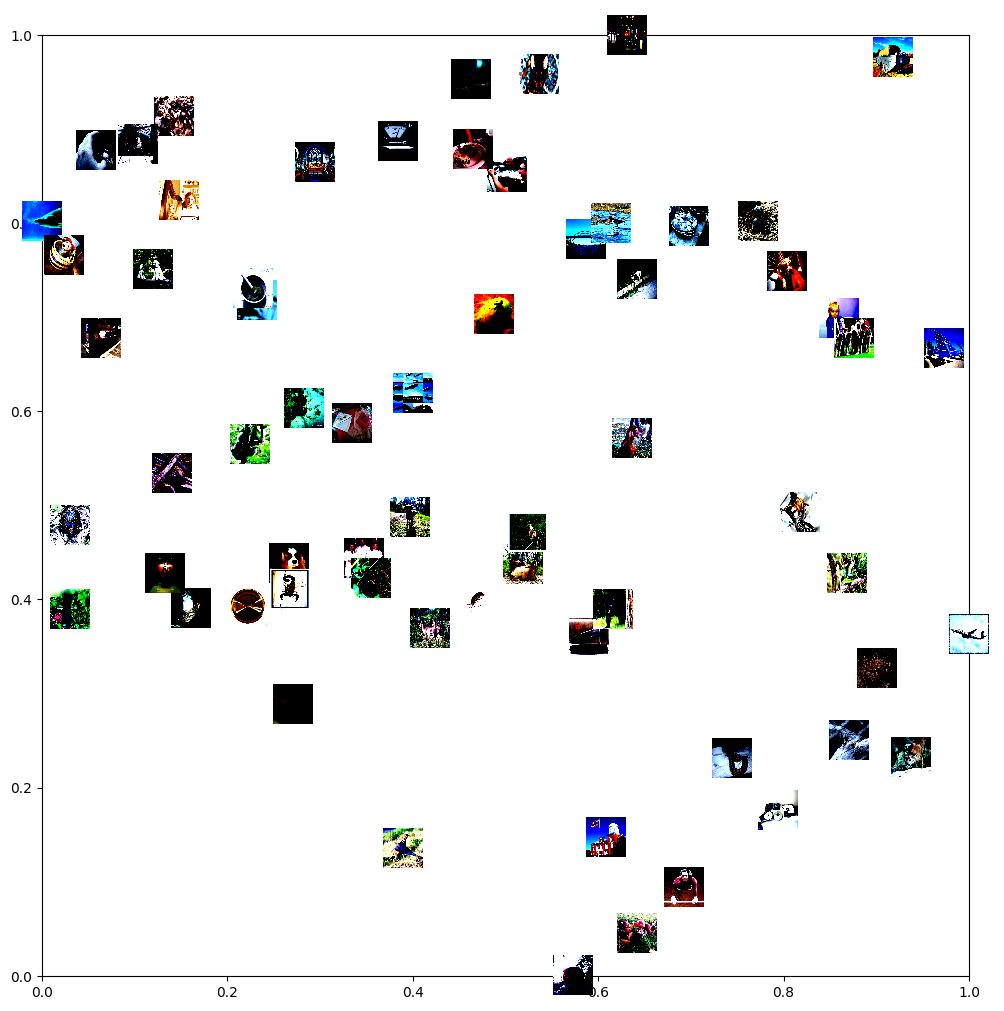

56 images in OPT cluster 25
50000
[49  1 13 28 37 23 33 47 51 55 14 19 38 46 16 50  0 24 53 33 35  9 13  9
 60 48 60 25  6 19 54 35 16 35 56 56 13 51  2 46 41 47 37 33  3  0 49  7
 20 54 39  6 62 16  4 13] [  433  1281  2189  3036  4325  4631  6433  6831  7731  9271  9678 13203
 13350 13358 14416 15218 18304 18776 20789 20961 21091 22473 22925 23049
 25212 26608 26620 27673 27974 28307 28918 29283 31248 32483 33976 34552
 34573 34675 34818 35438 36009 37167 37733 40097 40579 40640 40689 40839
 41108 41334 41767 41926 42878 44624 44676 44749]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

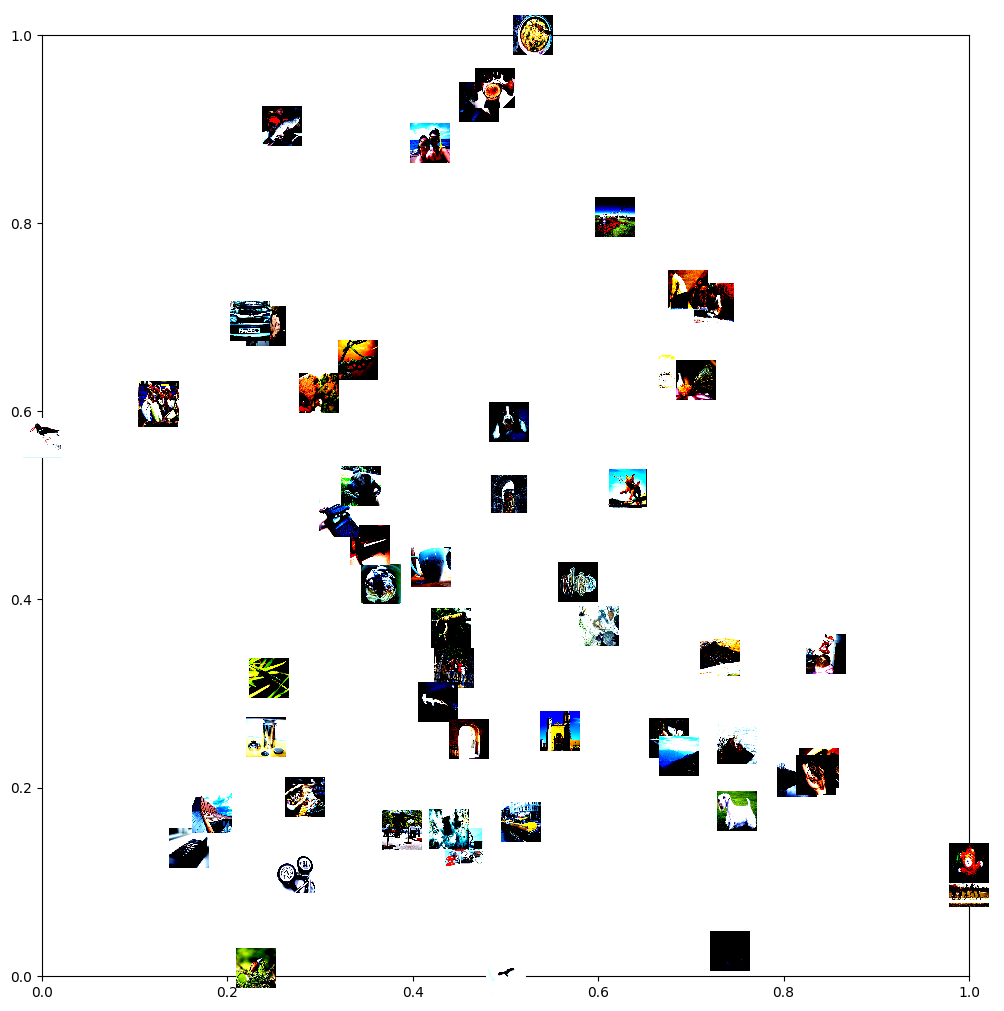

75 images in OPT cluster 26
50000
[12 60 22 26 14 39 14 10 23 50 18  4 39 58 63 39  3 51 45 48 15 31 31  2
 39 17 39  0 17 44 42  8 59 15 21 32 26 61 58 26 63 51 52 46  7 45 38 12
 51 17 34 35 15 53 45 58 19 63 50 18  5 25 30  8 27 51 36 21 59 39 36 16
 16 36  7] [  524   700  1046  2266  3918  4007  4110  4682  4951  4978  5394  6020
  6823  7226  7423  7591  8195  9715 11693 12208 12943 13407 14431 15874
 17063 17617 17639 17984 18065 18092 18154 19592 20283 20879 22357 25440
 25690 25789 26170 26202 26687 26803 27316 28782 29383 29421 29542 29964
 30131 30161 30306 30691 31311 32373 32877 33466 33747 33919 34290 34322
 34821 34905 36318 36360 38491 38899 39204 39253 42235 42599 43812 43856
 43984 44196 44295]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


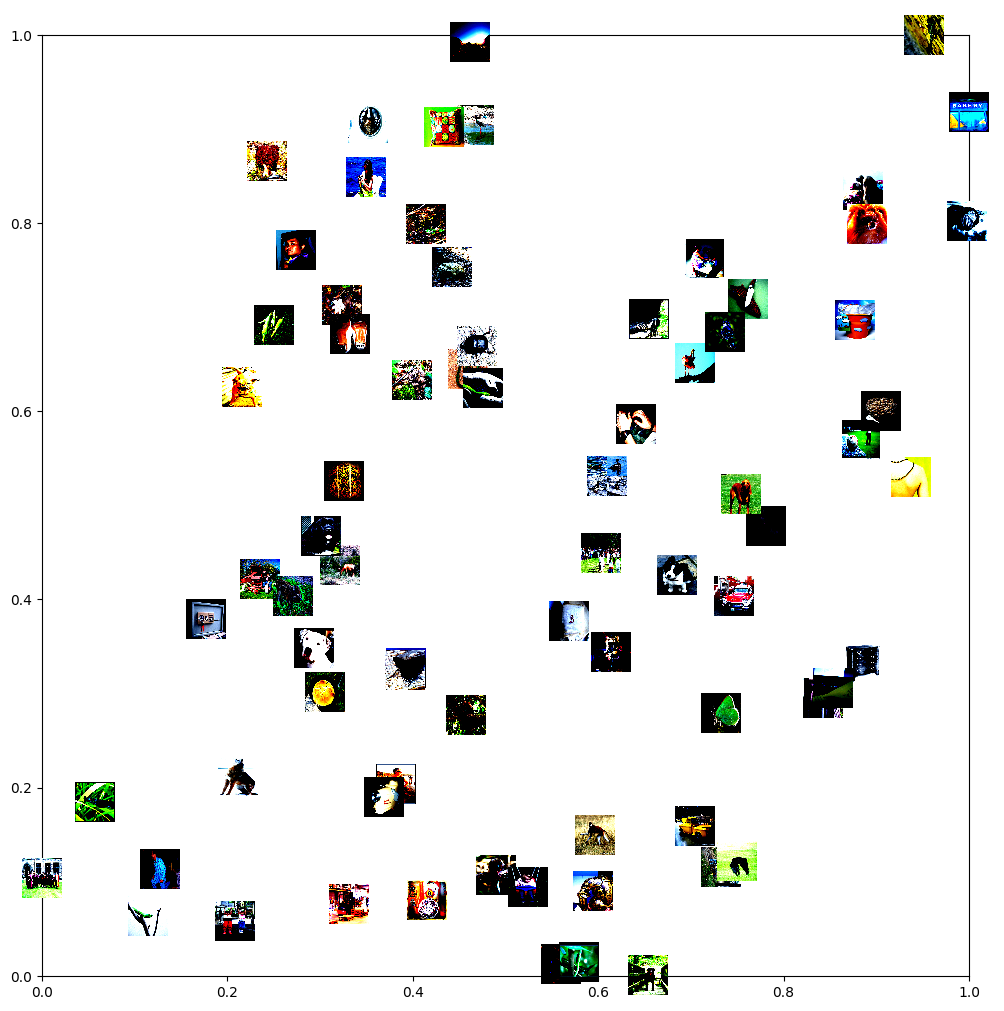

56 images in OPT cluster 27
50000
[34 47 26 16  6  2 48 38 51 56 37  0 13 57 56 31 43 52 29 15 31 27 37 39
 63 29 19 18  3 56 48 15 51 63 16 56 38 43 59 50  9 52 31  9  5  3 52 27
  5 39  7 13 53 53 39  6] [ 1186  2415  3290  4048  6406  9410 10160 11558 12147 12536 12709 13504
 14861 14905 17592 18207 18731 18740 19485 20111 20383 20955 21157 22183
 23615 24349 24659 26386 27139 28024 28144 29007 29491 29887 29968 30904
 31206 31403 31483 32562 32585 32628 33567 34441 35333 35395 35956 36379
 38533 40999 41351 41357 43637 44405 44583 44742]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

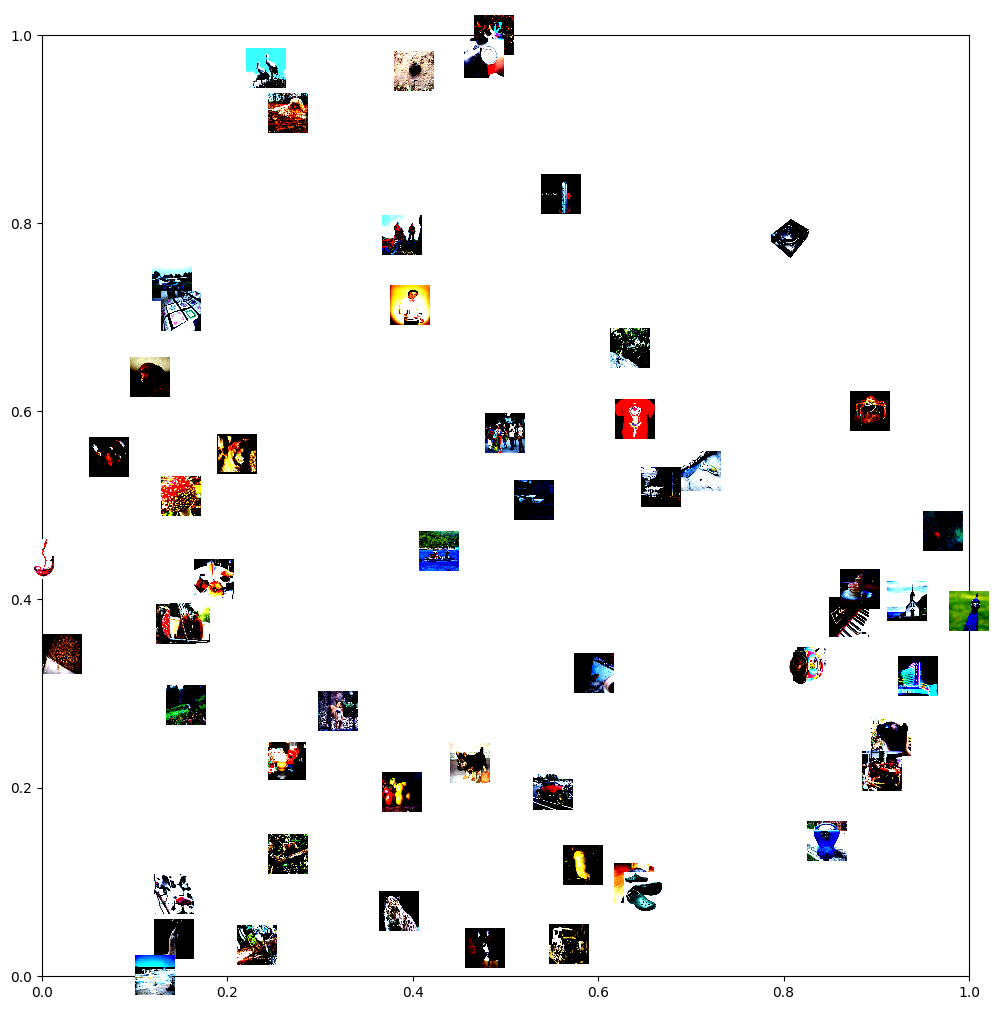

23 images in OPT cluster 28
50000
[26 33 11 55 63 54 59 49 33 18  0  8 18 58 14 11 37 24 50 51 51 18  8] [ 1050  1249  1995  2295  4287  4534  5819  9201 10273 10898 15616 18696
 20626 27706 27726 31819 33829 36056 37874 37939 40883 41234 43976]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

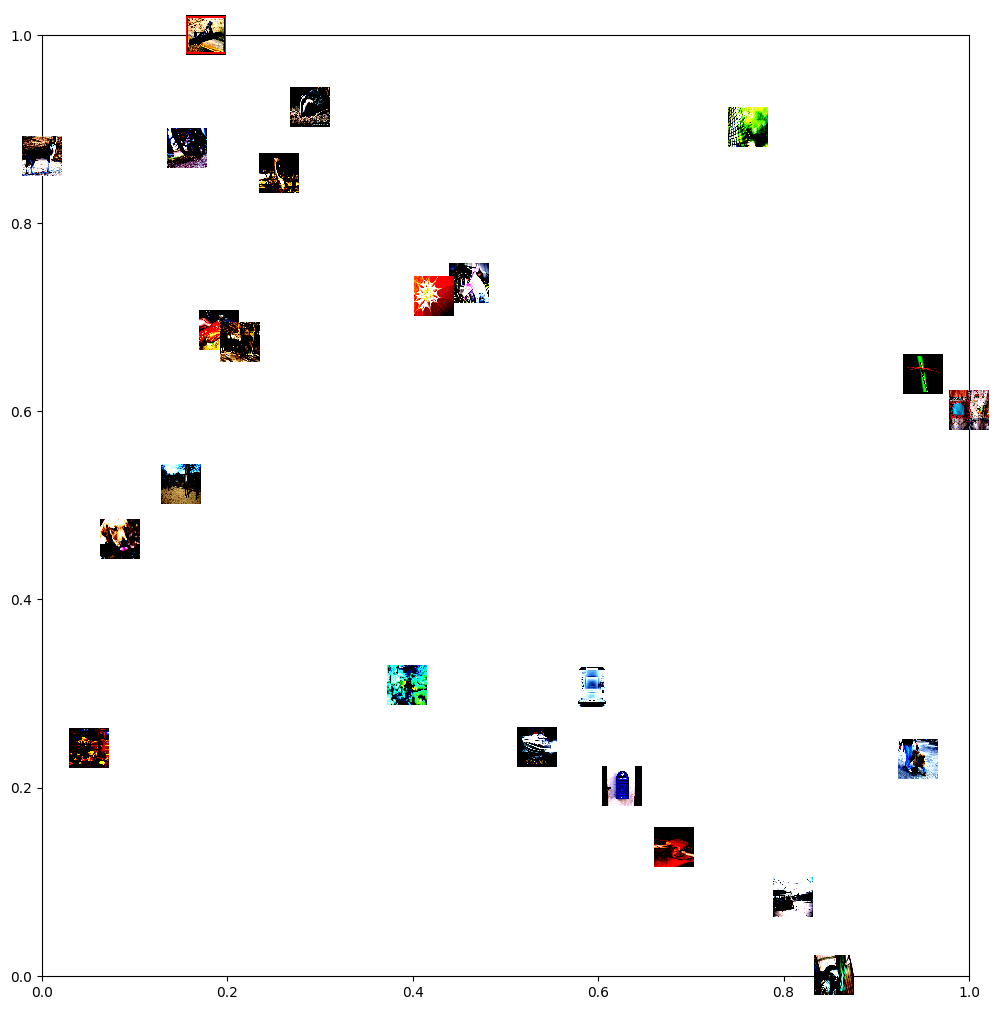

16 images in OPT cluster 29
50000
[55 25 41 43 11 27  4 36 51 36 29 26 29  8 19 53] [ 2423  3865  4713 11691 12107 13787 16068 16868 18035 22436 24797 28698
 34397 36168 41363 44085]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

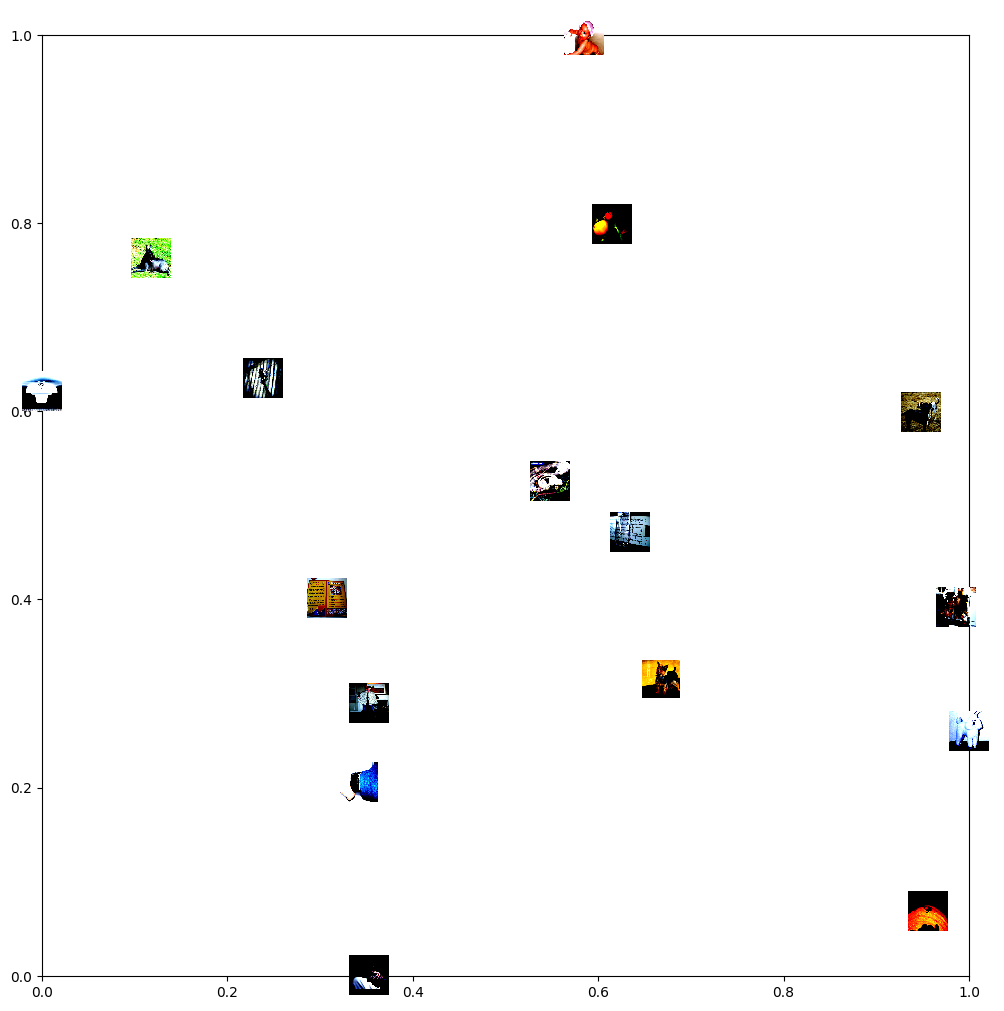

34 images in OPT cluster 30
50000
[20 39 49 10 16 20 55 61 63 12 57 58 63  1 20  9 46 11 41 28 39 20  0 40
 52 37 41 46 12 12 33 26 18 51] [ 1172  1383  1777  3146  3984  4820  6775  6845  7167  7308  9849  9850
  9855 12481 14548 14985 18222 19659 20073 20316 22951 25236 26304 26536
 29108 32229 36265 37166 37964 39948 40353 40602 43986 44147]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

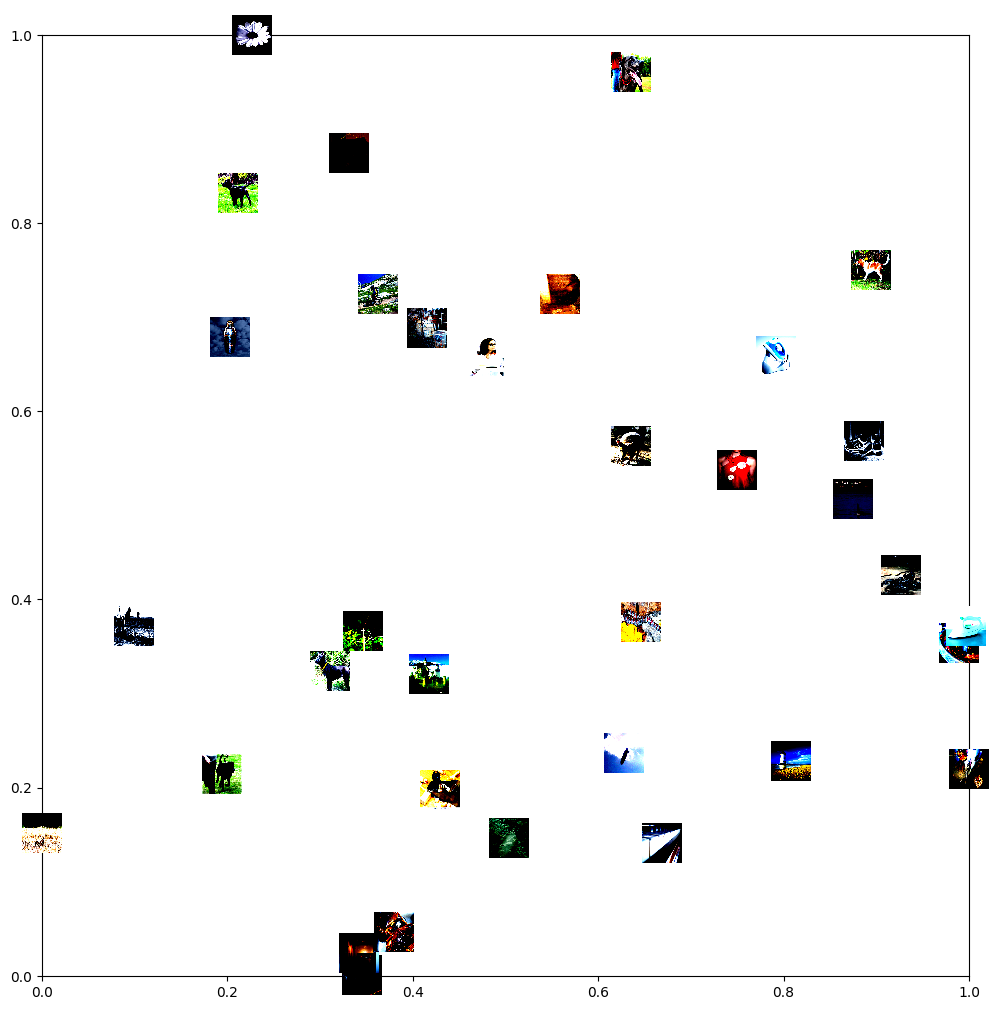

72 images in OPT cluster 31
50000
[16  4 20 44 48 15 63 53 26 31  7 46 37 56  4 48 33 50 24 55 62 63 39 59
 22 12 14 45 49  8 17 27 56 34 35 32 39 46  7  7 45 35 26 33 56 59 26  0
  1 15 16  3  2 42 48  1 40 20  0 15 35 28 49 57 54 44 51  5 48 45 18 26] [  208   964  1492  3628  4144  5007  5567  5813  6170  7007  8391  8494
  8933  9656 10052 10544 11361 11954 12184 12471 12478 12991 13095 13243
 14166 14412 14990 15341 15345 16008 16145 16731 16952 17250 17507 19488
 19495 20206 21255 22343 23341 23779 24602 25313 26040 26555 27418 27712
 29057 31119 31760 33027 34434 34538 34544 35713 35880 36500 36800 37327
 37603 39132 39217 39289 40694 41004 41395 41797 42288 44077 44626 44826]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


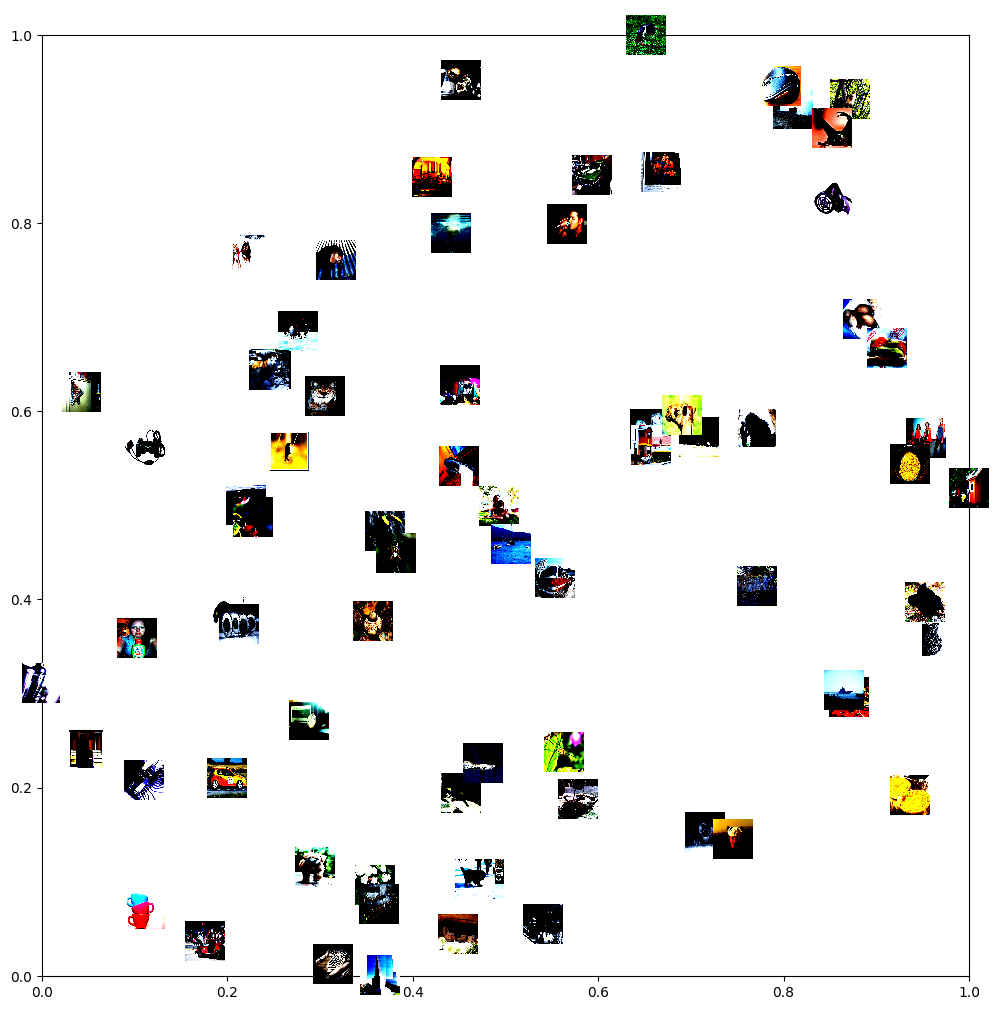

40 images in OPT cluster 32
50000
[20  5 55 40 36 27 49 27 30 13 61 41 18 54 22 33 22 36 60 55 36 59 40  6
 12 21 28 30 49 11 31 37 22 24  6 14 37 22 27  5] [  212  1157  1847  1896  1956  3867  4017  4571  5022  5133  5373  7145
  7442  9398  9750 10465 11606 11812 12540 13111 15076 15163 17256 18694
 19276 19797 20956 21086 23345 24331 24351 27813 30230 33624 33926 36366
 42661 44310 44315 44741]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

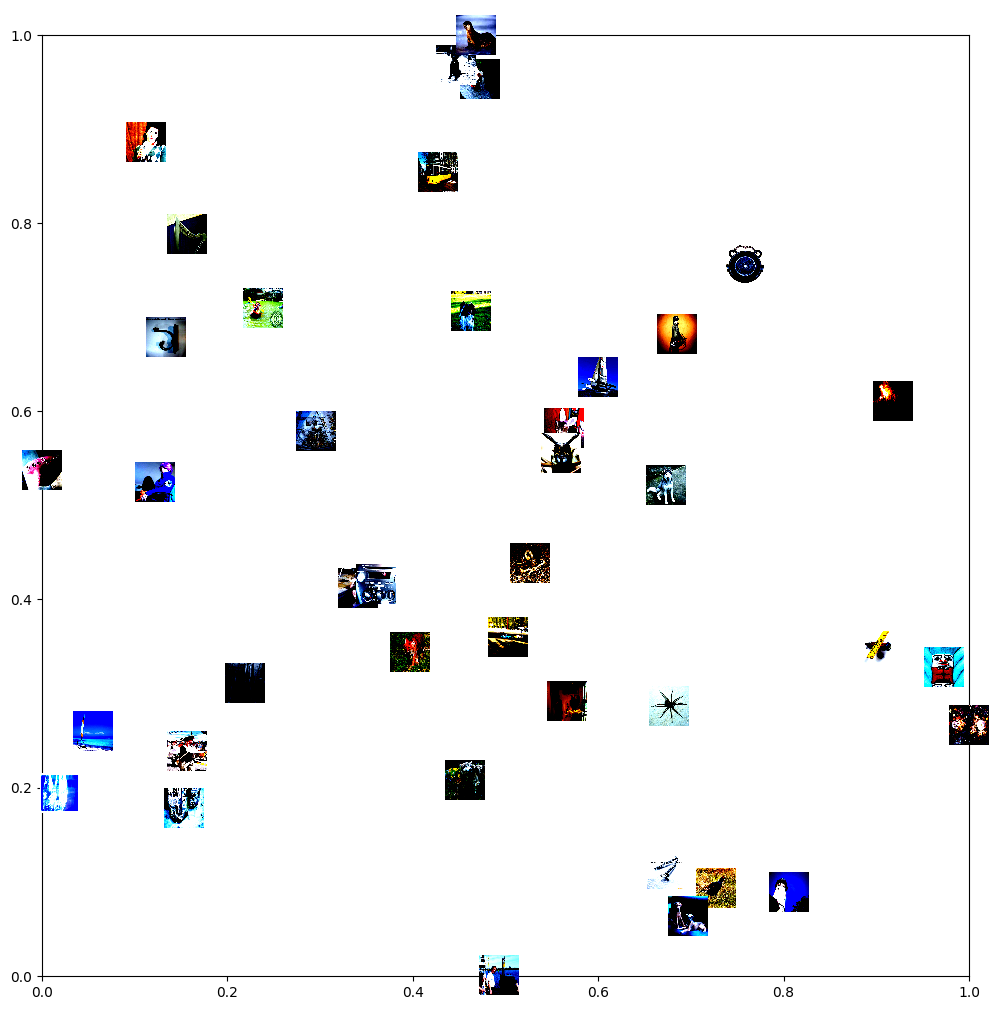

50 images in OPT cluster 33
50000
[38 55 39 35 63  9 62 49 26  0 11 12 18 57 21  9 40 31 25  0 37 14  8 31
 13 52 58  3 49 10  6 35 21 21 53 45 19 17  7 46 49 47 18 24 20 11 62 41
 32 32] [  614  1015  2215  3555  3647  4361  4734  5169  7898  9408  9547  9740
 11858 13049 13269 13513 16232 17695 18713 19776 21861 22030 22088 24671
 25037 25140 26746 27779 28145 28874 29638 31587 32789 33173 33589 35373
 35731 35793 36551 37614 39025 39279 40018 40088 41300 41611 42686 42921
 43232 44384]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

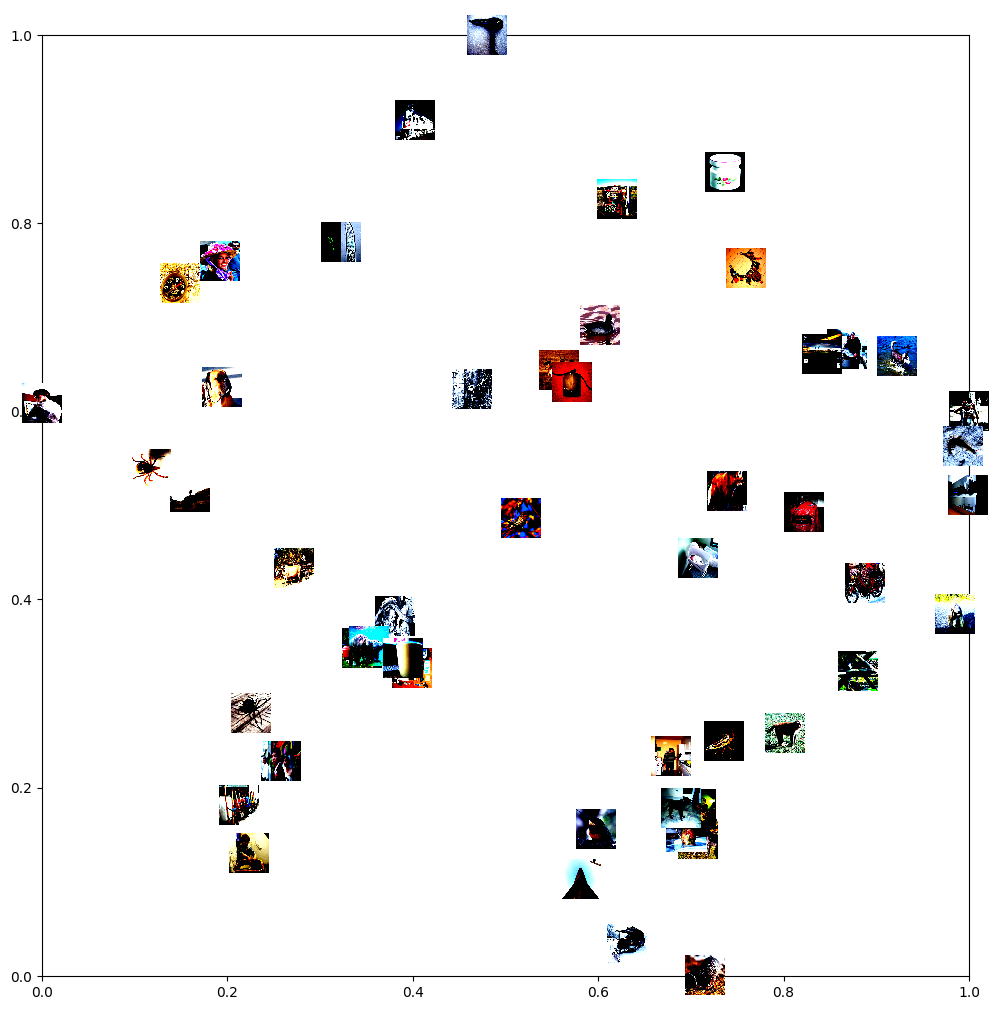

45 images in OPT cluster 34
50000
[ 9  3 24 16  5  8 55 35  0 44 38  3 13 37 17  9 43  8 22  4 29 45 27 20
 17 12 20 16 31  2 18 57 61 46 53 38 17 31 14 63 62 35 58 63 44] [  265  2691  4440  8528 11397 11592 12087 12899 14016 14252 14886 15171
 15757 16549 17553 17929 20715 22600 22614 22916 23709 24301 24923 27092
 27985 29004 29140 31312 31327 32322 33170 34041 34493 34734 35509 37414
 37777 39583 40142 41791 42366 43107 43578 43903 44268]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

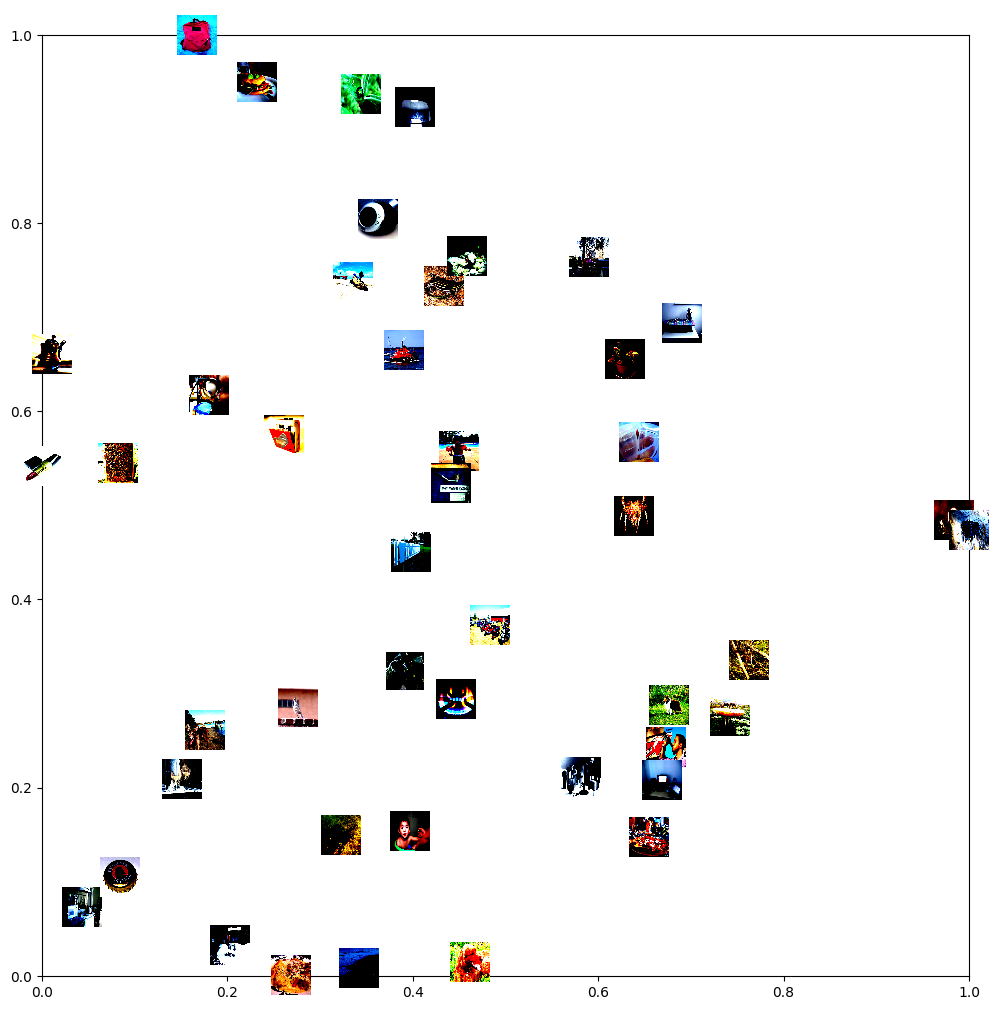

13 images in OPT cluster 35
50000
[28 28 27  6 12 55 36 31 36 21 14 22 59] [   92   412  7067  7302 14156 14775 16356 19295 23268 29397 30862 35478
 44539]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

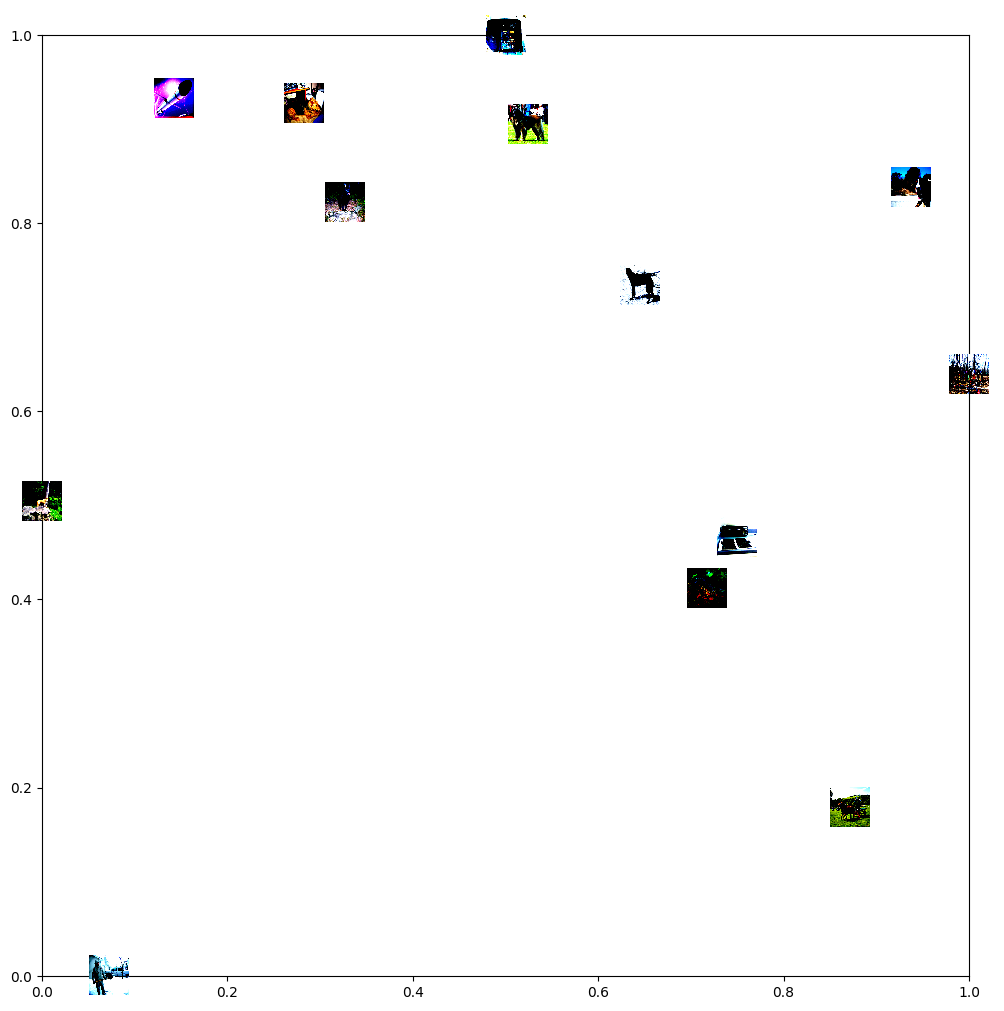

20 images in OPT cluster 36
50000
[14 48 55 49 18  6 36 31 52  9 61 34 53 28 38  9 56 39  4 21] [  334   688  5239  6705  8658  9542 13668 15391 18420 19721 20477 24226
 28213 29020 30630 32457 34168 36199 37508 41493]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

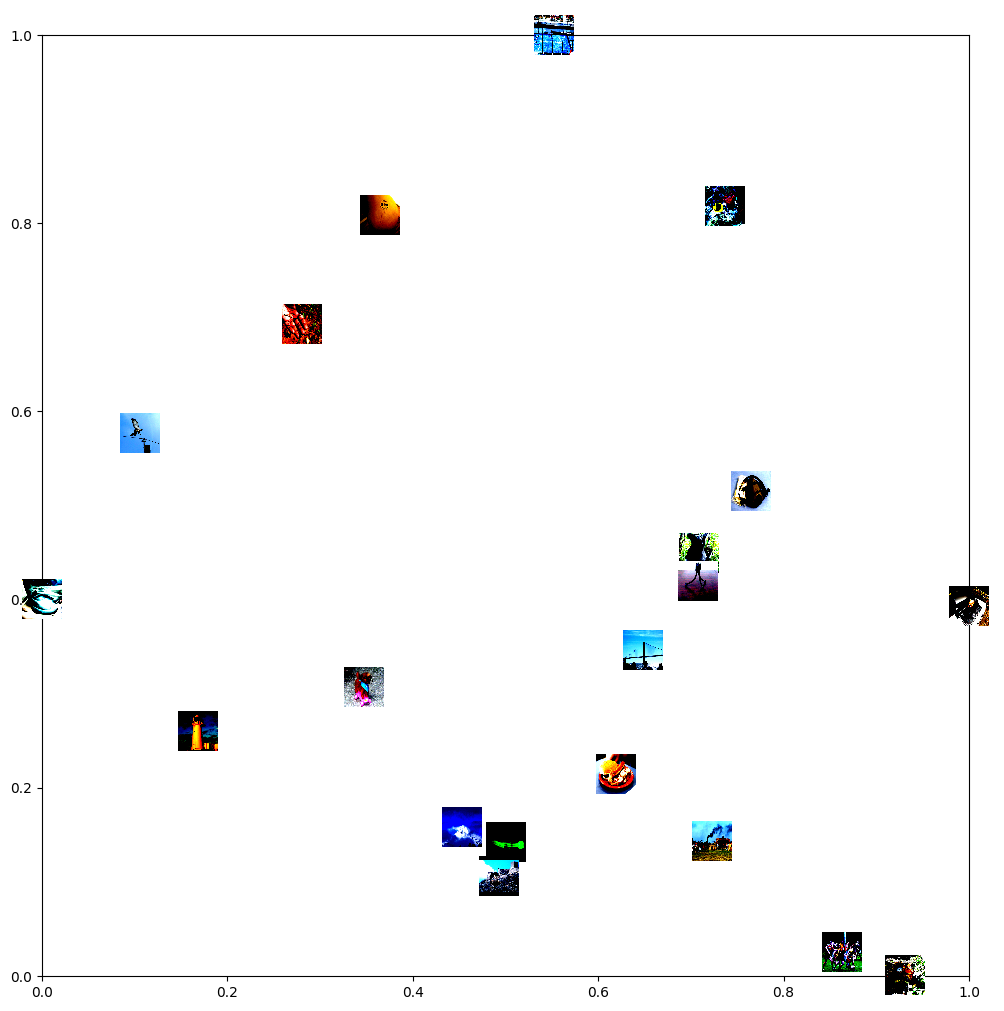

23 images in OPT cluster 37
50000
[60 38 12  7 43 46 32 47 53 31 12 32 37 35 46 15 30 31 63 52 19 16 10] [ 1148  9574 12364 13255 16427 17390 19168 22447 22645 27807 29900 31712
 32869 33059 34030 34255 35934 37023 39807 40500 42643 44304 44554]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

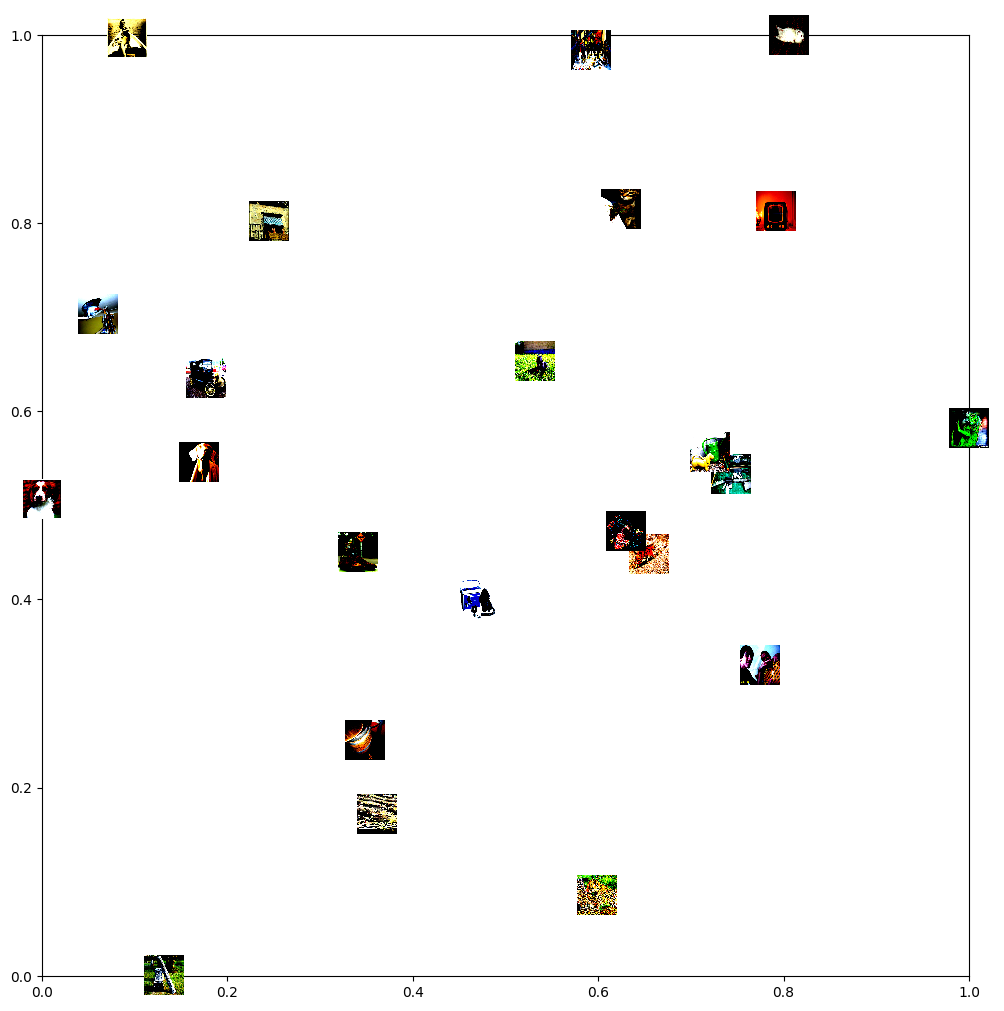

44 images in OPT cluster 38
50000
[62 51 54 35 61  9 41 23 47 14 21 15 24 49 26 20 44 43 57  0 13 34 33 45
 23 33 17 53 15 10 56  5 55 40 42 42 56 59 48 24 22 32  7  5] [  254   947  2550  2595  2685  4233  7657  8279  8751  9230  9557 10703
 11992 12529 13594 14228 14380 14507 15225 16512 18637 20066 20641 23405
 23511 23841 27601 28533 29647 29834 32504 35205 35319 37736 37866 38314
 39736 39867 42224 42904 43350 43488 43719 44357]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

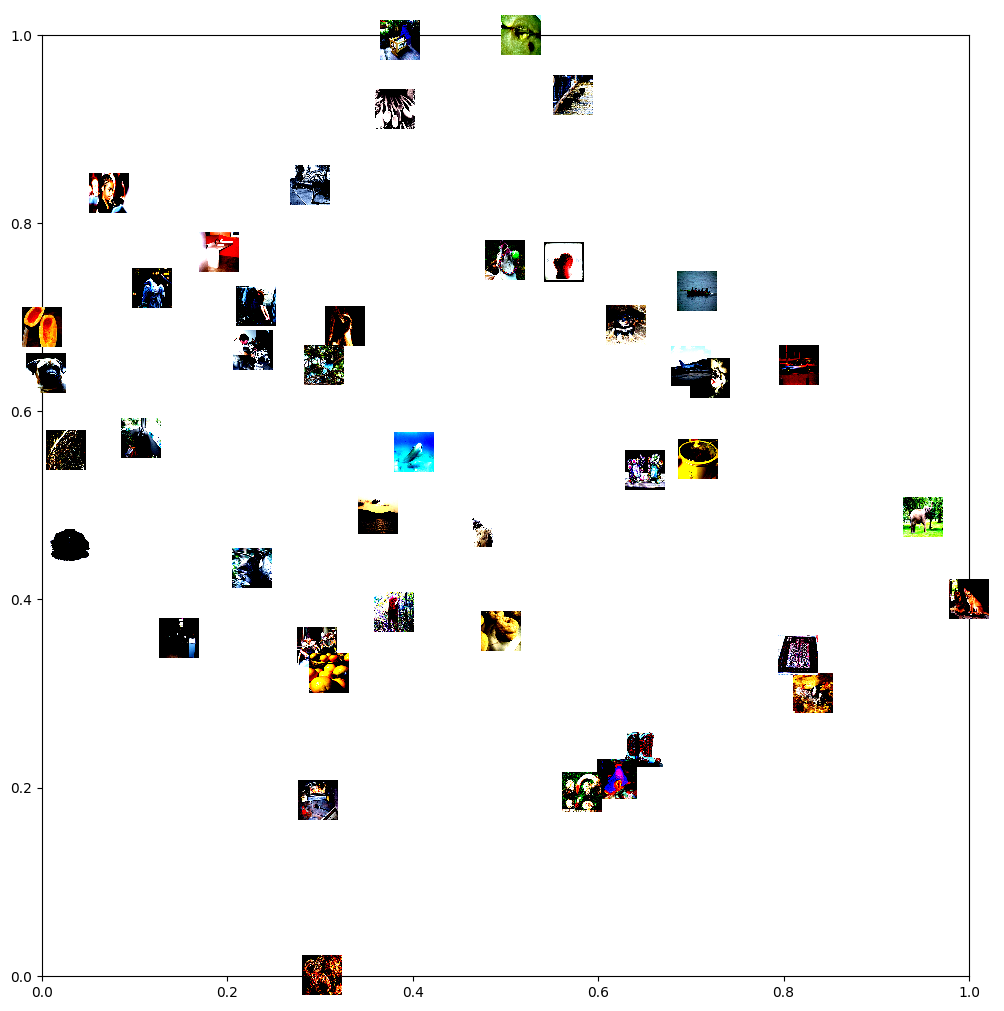

83 images in OPT cluster 39
50000
[28 13 60 18 17 32 53  9 41  9 44 49  2  4 44 39 60 45 39  0 40 62 14 11
 19 61 54 56 29 27 37  2 34 17 55 12 31 26 35 35 57  5 14  9 15 58 60 11
 27  5  8 10 58 43 14 31 30 33 24 60 34 39 16 10 56 48 39  1 29 25 22 59
 47 57 33  6 25 28 26  6  4  4 54] [ 1180  1485  1532  2706  3281  3680  4405  4937  4969  5769  5932  6385
  6978  6980  7468  9575 11324 11949 12135 12608 14504 14526 15054 15819
 15827 16253 16566 16568 17885 18651 19109 19586 19938 20305 20983 22412
 22495 23002 23331 23395 23929 24197 26574 26953 26959 27194 27260 27467
 28315 28357 28552 30794 30970 31083 31310 31839 31902 32097 33176 33212
 33314 34599 35408 36298 36408 36656 36775 36993 37277 38105 38166 38331
 38703 38777 39649 40518 40729 40924 43034 43334 44164 44292 44854]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

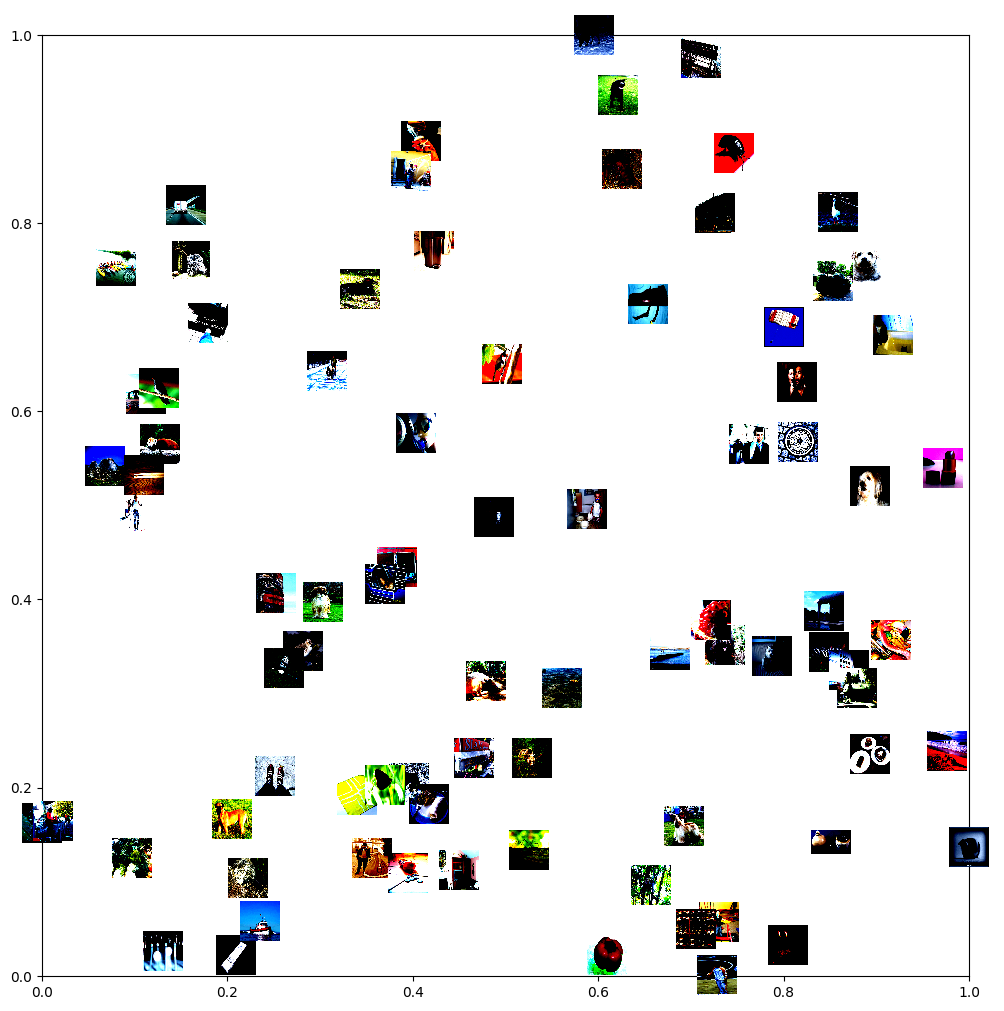

42 images in OPT cluster 40
50000
[19 38 41 27 58 53 28  9 53 29 15 58 19 51 35 60 20 20 45 50 14 19  8 17
 27 23 22 17 61  7 44 59  1 30 17 58 48 28 14 36 42 32] [   83   166   297  1243  3642  5237  5852  7561  7669 10845 11407 11514
 12051 12467 15203 15356 17492 18196 18605 20146 21646 22739 22920 24017
 25051 27031 31254 31889 32829 33223 34860 34875 34881 35166 38353 39226
 40176 40604 41230 43620 44138 44320]


/homedtcl/mmahaut/.conda/envs/omelette/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# quick look into the images in the two types of available clusters
# print("portion of kmeans & OPTICS overlap :", (clust.labels_ == clust2.labels_).mean())
clust = clust2
X = X_pca
for i in range(max(clust.labels_)):
    print(f"{len(X[clust.labels_ == i])} images in OPT cluster {i}")
    indexes = np.where(clust.labels_ == i)[0]
    fig = plt.figure(figsize=(10, 10))
#     get images
    images = look_at_image(indexes, df_inter, get_dl(False))

#     show batches
#     plot_batch(indexes, df_inter, get_dl(False))
    
#  plot as a grid
#     for i,im in enumerate(images):
#         if i > 63:
#             break
#         fig.add_subplot(8, 8, i+1)
#         plt.imshow(im)
#     plt.show()

# plot according to distance
    X_temp = X[clust.labels_ == i]
    v = X_temp[:,0]
    X_temp[:,0] = (v - v.min()) / (v.max() - v.min())
    v = X_temp[:,1]
    X_temp[:,1] = (v - v.min()) / (v.max() - v.min())

    plot_image_on_positions(X_temp,images)
    plt.show()


In [ ]:
# we display images that were chosen for a given messages (or its nearest approximation), with increasing perturbations along a chosen axis
# so as to get an idea of the information stored along each axis
message = [0.2] * 16
df_inter = df_inters[-1]

# seed_all(111)
# repeat after adding a distraction on chosen axis
perturbation_axis = 6
n_perturbations = 100
indexes = []
for i in range(n_perturbations):
    message[perturbation_axis] = i / n_perturbations
    indexes.append(find_similar(message, df_inter))

fig = plt.figure(figsize=(15, 15))
dl = get_dl()
for i,im in enumerate(look_at_image(indexes, df_inter, dl)):
    fig.add_subplot(8, 8, i+1)
    plt.imshow(im)

plt.show()
# eyeball the images along the chosen axis, see if something comes out of it


In [ ]:
# find n closest images to one_hot message on a given axis
# a bit slow ~50s * 16 dimensions
df_inter = df_inters[-1]

for dim in range(16):
    message = [0] * 16
    message[dim] = 1 # <-- chooses dimension here

    dl = get_dl() # <-- seeding occurs when we fetch dataloader, reproducibility is ensured

    val, ind = find_n_similar(message, df_inter, n_values=10)

    fig = plt.figure(figsize=(15, 15))
    for i, im in enumerate(look_at_image(ind, df_inter, dl)):
        fig.add_subplot(1, 10, i+1)
        plt.imshow(im)
    plt.show()

## PCA analysis
lets make an n component PCA with the scikit-learn tool, to get a visual idea of clusters and their correspondance to the pretrained 'human' classes

In [1]:
## Parameter Selection
# select which senders and which pretraining class labels to visualise 
# Chosing fewer may facilitate analysis as less overlap happens
_chosen_sender_index = _chosen_sender_index = [0,1,2,3,4,5] # [0]
_chosen_labels = _chosen_labels = [i for i in range(1000)] #[1,16,38]
# PCA parameters
n_components=10
# PCA dimensions to show on graph
prin_comp_A = 1
prin_comp_B = 2

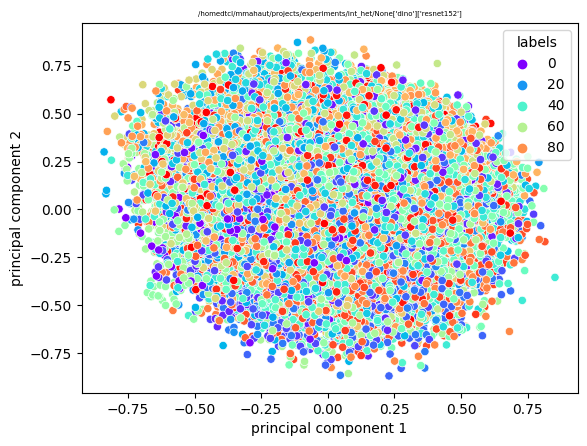

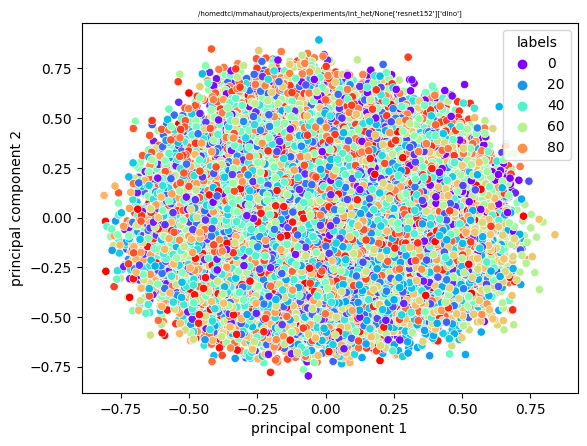

In [4]:
df_pcas = []
pcas = []
# lets get those sender specific PCAs
for i,df_inter in enumerate(df_inters[:2]):
    plt.figure()
    # taking only the interactions that have the matching indexes for the chosen sender and the class labels
    selectedsender_interactions = df_inter[df_inter.sender_idx.isin(_chosen_sender_index)][df_inter.labels.isin(_chosen_labels)] 

    # PCA
    pca = PCA(n_components)
    pcas.append(pca)
    x = selectedsender_interactions.loc[:, selectedsender_interactions.columns.str.contains('dim')]
    principalComponents = pca.fit_transform(x)
    df_pca = pd.DataFrame(data = principalComponents
                , columns = [f'principal component {i+1}' for i in range(n_components)])
    ## If we were to reuse those dimensions, this is what they look like : 
    # print(df_pca[['principal component 1','principal component 2']].sample(3))
    df_pcas.append(df_pca)
    
    # plotting PCA
    sns.scatterplot(x=df_pca[f'principal component {prin_comp_A}'],
        y=df_pca[f'principal component {prin_comp_B}'], 
        hue = selectedsender_interactions.set_index(df_pca.index).labels,
        #ax=axes[i] if len(df_inters) >1 else axes,
        palette='rainbow',
    ).set_title(interaction_files[i], fontsize = 5)
    # ax.grid()

In [ ]:
for pca in pcas:
    fig, ax = plt.subplots()
    eigenvalues = pca.explained_variance_
    ax.bar(range(1,len(eigenvalues)+1),eigenvalues)
    ax.set_title(interaction_files[i], fontsize = 5)
    
# TODO : add title and axis

n_classes =  999


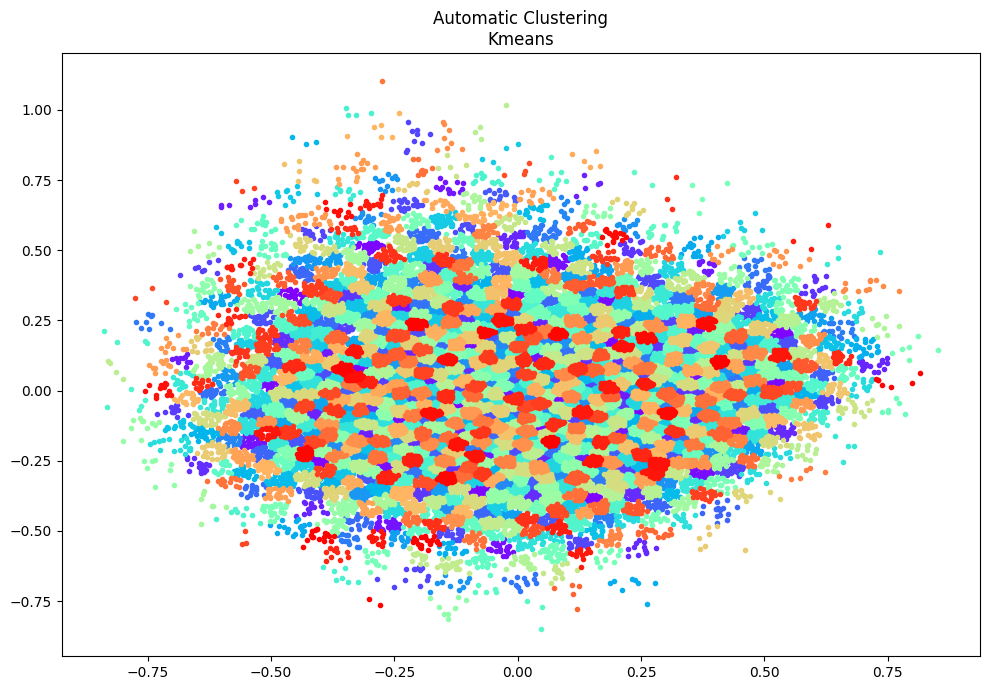

n_classes =  999


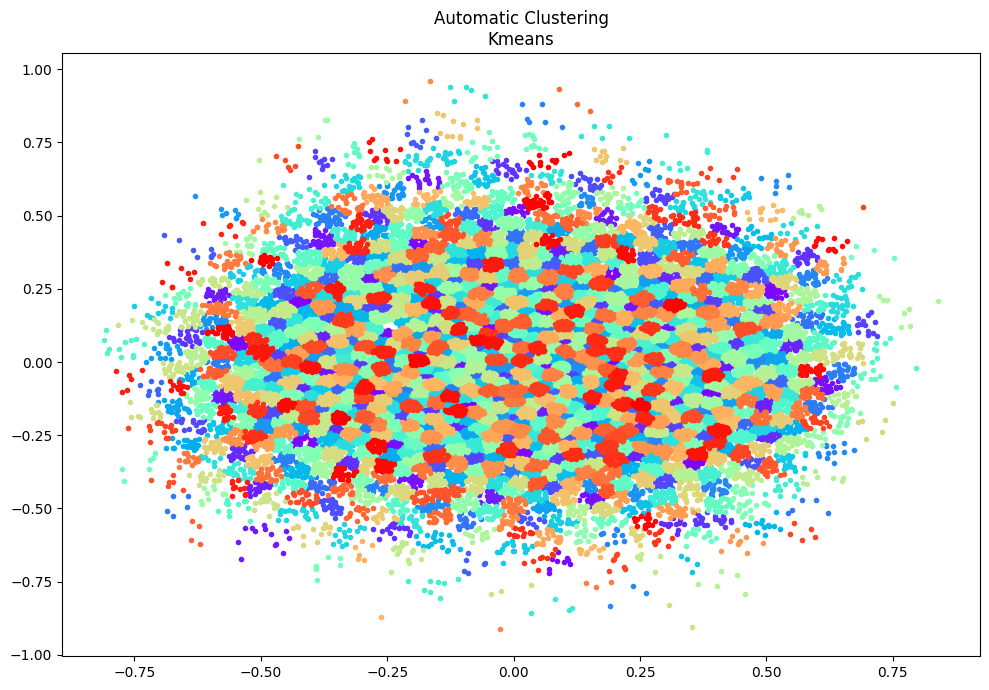

In [5]:
# clustering the PCA
for df_pca in df_pcas:
    X_pca = df_pca.loc[:,df_pca.columns.str.contains('1' or "2" or "3" or "4")].values
    clust2 = KMeans(1000)
    clust2.fit(X_pca)
    labels = clust2.labels_
    
    # PLOT
    # set colors
    color = iter(cm.rainbow(np.linspace(0, 1, max(labels))))
    # plot figure
    plt.figure(figsize=(10, 7))
    G = gridspec.GridSpec(1, 1)
    ax = plt.subplot(G[0, :])
    # ax.plot(space, np.full_like(space, 1.0, dtype=float), "k.", alpha=0.3)
    print("n_classes = ",max(labels))
    colors = plt.cm.get_cmap("hsv", max(labels))
    for klass in range(max(labels)):
        Xk = X_pca[clust2.labels_ == klass]
        c = next(color)
        ax.plot(Xk[:, 0], Xk[:, 1], ".", color=c)
    ax.plot(X_pca[clust2.labels_ == -1, 0], X_pca[clust2.labels_ == -1, 1], "k+", alpha=0.1)
    ax.set_title("Automatic Clustering\nKmeans")
    plt.tight_layout()
    plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [5, 4]
plt.rcParams["figure.autolayout"] = True
# temporary : slight graph cosmetic modifications
# PLOT
# set colors
color = iter(cm.rainbow(np.linspace(0, 1, max(labels))))
# plot figure
plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(1, 1)
ax = plt.subplot(G[0, :])
# ax.plot(space, np.full_like(space, 1.0, dtype=float), "k.", alpha=0.3)
print("n_classes = ",max(labels))
colors = plt.cm.get_cmap("hsv", max(labels))
for klass in range(max(labels)):
    Xk = X_pca[clust2.labels_ == klass]
    c = next(color)
    ax.plot(Xk[:, 0], Xk[:, 1], ".", color=c)
ax.plot(X_pca[clust2.labels_ == -1, 0], X_pca[clust2.labels_ == -1, 1], "k+", alpha=0.1)
ax.set_title("Automatic Clustering\nKmeans")
plt.tight_layout()
plt.show()

In [ ]:
# control experiment :
# PCA but on basic images before going through communication game (or any feature extraction)
from egg.zoo.pop.data import get_dataloader
v_loader, t_loader = get_dataloader(
            dataset_dir="./data",
            dataset_name="cifar100",
            image_size=384,
            batch_size=64,
            num_workers=0,
            is_distributed=False,
            seed=111,  # same as hardcoded version used in experiments
            use_augmentations=False,
            return_original_image=False,
            split_set=True,
            augmentation_type=None
        )

data = []
i = 0
for i, image in enumerate(v_loader):
    if i>= 2000:
        break
    data += image[0]
    i+=1
data = [im.flatten().numpy() for im in data]   


In [ ]:
# clustering the original images
X_pca = np.array(data)
clust2 = KMeans(200)
clust2.fit(X_pca)
labels = clust2.labels_

In [ ]:
len(np.unique(labels))

In [ ]:
X_pca.shape

In [ ]:
# PLOT
# set colors
color = iter(cm.rainbow(np.linspace(0, 1, max(labels))))
# plot figure
plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(1, 1)
ax = plt.subplot(G[0, :])
# ax.plot(space, np.full_like(space, 1.0, dtype=float), "k.", alpha=0.3)
print("n_classes = ",max(labels))
colors = plt.cm.get_cmap("hsv", max(labels))
for klass in range(max(labels)):
    Xk = X_pca[clust2.labels_ == klass]
    c = next(color)
    ax.plot(Xk[:, 0], Xk[:, 1], ".", color=c)
ax.plot(X_pca[clust2.labels_ == -1, 0], X_pca[clust2.labels_ == -1, 1], "k+", alpha=0.1)
ax.set_title("Automatic Clustering\nKmeans")
plt.tight_layout()
plt.show()

## Some other basic things
Looking at the message distribution for intuition of where the information is hidden

In [ ]:
melted_dfs = []
for df_inter in df_inters:
    # Setting each dimension column as a categoric variable (called dim) of the same type (message value)
    _melted_df = df_inter.melt(["sender_idx","loss_idx", "recv_idx", "labels", "receiver_output", "batch_number"], var_name="dim", value_name="message_value")
    _melted_df.dim.replace([f"dim_{n}" for n in range(16)],[n for n in range(16)], inplace=True)
    melted_dfs.append(_melted_df)
print(melted_dfs[0].sample(3)) # have a look here if needed 

### Message Distribution

In [ ]:

## Parameter Selection
# select which senders and which dimension to visualise 
_chosen_sender_index = [0,3]   # _chosen_sender_index = [0,1,2,3]
_chosen_dimensions= [1, 3, 13] # _chosen_labels = [i for i in range(16)]

sns.set(rc={'figure.figsize':(5*len(melted_dfs),10)})
fig, axes = plt.subplots(2,len(melted_dfs)) 

# extract and plot
for i,melted_df in enumerate(melted_dfs):
    melted_df = melted_df[melted_df.sender_idx.isin(_chosen_sender_index)][melted_df.dim.isin(_chosen_dimensions)] # filtering senders
    sns.violinplot(x=melted_df.sender_idx, y=melted_df.message_value, hue=melted_df.dim, palette=sns.color_palette("tab20",16),ax=axes[0,i]).set_title(interaction_files[i])
    sns.violinplot(x=melted_df.dim, y=melted_df.message_value, hue=melted_df.sender_idx, palette=sns.color_palette("tab20",16),ax=axes[1,i])
    

# WIP : maybe add some statistical testing
# the way the violins look allow us to know where to set the saturation point were we to discretise

A quick look at the data distribution for messages in each dimension

Now we check if data distribution is modified by the class of the represented image (which it should if it wants to discriminate images)

In [ ]:
## Parameter Selection
# select which senders and which classes to visualise 
_chosen_sender_idxs = [0,1,2,3]
_chosen_labels = torch.randint(0,100,[5]) # three random labels
_chosen_dimensions= [1, 3, 13] # _chosen_labels = [i for i in range(16)]


sns.set(rc={'figure.figsize':(10*len(_chosen_dimensions),4*len(_chosen_labels))})
fig, axes = plt.subplots(len(_chosen_labels),len(melted_dfs)) 

for i,melted_df in enumerate(melted_dfs):
    for j, label in enumerate(_chosen_labels):
        _df = melted_df[melted_df.labels==label.item()]
        _df = _df[melted_df.sender_idx.isin(_chosen_sender_idxs)]
        _df = _df[melted_df.dim.isin(_chosen_dimensions)]
        if len(_df) != 0:
            sns.violinplot(x=_df.dim, y=_df.message_value, hue=_df.sender_idx, ax=axes[j,i]).set_title(interaction_files[i] if j == 0 else None)

# We can see variations in dimensional distribution depending on the pre-training classes. Each sender seems to encode it in a similar manner ! 
# (which can be understood as either an approximation of the actual clustering, or perhaps the beginning of an analysis of model capacities in out-of-scope contexts)
# vit, the agent with the most different representation, is in orange (sender_idx = 1). We can see it is always using slightly different communication distributions
# vgg (blue, idx = 0) seems to be the worst tricked by data_augmentation

### Dimension correlation

In [ ]:
# Ok. Correlation between dimensions now. Are any dimensions unnecessary ?
fig, axes = plt.subplots(1,len(df_inters)) 
for i,df_inter in enumerate(df_inters):
    # Compute the correlation matrix
    # (just on the dims, not on the rest of the information in interactions)
    corr = df_inter.loc[:,df_inter.columns.str.contains('dim')].corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},ax=axes[i]).set_title(interaction_files[i])

# looks quite independant no ? with that in mind they'd all be necessary.

lets add :
* Independance of dims test
* entropy of pop languages vs one on one languages
* 